# **Modelos de regresión para la predicción** 

En este ejercicio, nuestro objetivo es desarrollar un modelo predictivo para estimar la velocidad del viento horaria. Para abordar este problema, utilizaremos cuatro enfoques de regresión: **K-Nearest Neighbors (KNN)**, **Regresión Lineal**, **Regresión Ridge**, y **Regresión Lasso**. La predicción se realizará considerando tanto las diferentes ventanas temporales de pronóstico (7, 14, 21 y 28 días), como el ciclo horario completo de 24 horas de un día.

A continuación, las librerías y módulos usados.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.svm import SVR
import statsmodels.api as sm
from skopt import gp_minimize
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from skopt.space import Integer, Categorical, Real
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, mean_absolute_error

En primer lugar, procederemos a importar la base de datos obtenida luego de finalizar el análisis exploratorio de los datos.

In [2]:
data = pd.read_csv("C:/Users/valcd/OneDrive/Escritorio/dataparcial2.csv")
data

,hora,direccionviento,velocidadviento,humedadmaxima,humedadminima,temperaturamaxima,temperaturaminima,precipitaciontotal,rafagamaxima,presion_atm_maxima,presion_atm_minima
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,0.0,3.8,888.2,887.7
1,13:00,0.965926,2.7,62.0,55.0,24.2,22.5,0.0,4.7,888.4,888.2
2,14:00,0.891007,2.0,56.0,50.0,25.5,24.3,0.0,4.9,888.4,888.1
3,15:00,0.848048,2.5,52.0,44.0,27.4,25.0,0.0,5.8,888.1,887.4
4,16:00,0.224951,2.4,50.0,43.0,27.1,25.5,0.0,5.8,887.4,886.5
...,...,...,...,...,...,...,...,...,...,...,...
87688,19:00,-0.615661,5.6,83.0,78.0,21.8,21.1,0.0,12.3,879.8,879.1
87689,20:00,-0.469472,4.9,84.0,79.0,21.7,21.0,0.0,9.9,879.2,878.9
87690,21:00,-0.484810,4.5,86.0,82.0,21.2,20.6,0.0,8.9,879.8,879.2
87691,22:00,-0.484810,3.2,88.0,85.0,20.6,20.2,0.0,8.0,880.5,879.6


Luego, particionamos la base de datos en dos partes. **X** que corresponde a todas las variables explicativas e **y** que corresponde a la variable respuesta.

In [3]:
X = data.drop(columns=['hora','velocidadviento']) # Se toman todas las columnas excepto la objetivo
y = data['velocidadviento'] # Se toma solo la columna objetivo

Creamos este vector que contiene las ventanas de predicción para este ejercicio.

In [4]:
particiones = [7, 14, 21, 28] # Vector que almacena el valor de las particiones estipuladas. En DIAS.

## **MÉTODOS ÚTILES PARA LOS MODELOS**

In [4]:
# Mejor modelo por hora

def mejormodelohora(particiones, data):  
    mejormodelo = []  
    for i in range(1, 25): # Recorre las 24 horas del día
        mejorrmse = float('inf')  
        mejor_modelo = None  
        for dias in particiones: # Recorre las 7 ventanas
            condicion = data[(data['Hora'] == i) & (data['Dias'] == dias)] 
            if not condicion.empty: 
                # Se busca la fila con menor RMSE entre todas
                for idx, row in condicion.iterrows():
                    if row['RMSE'] < mejorrmse:
                        mejorrmse = row['RMSE']
                        mejor_modelo = row     
        if mejor_modelo is not None:
            mejormodelo.append(mejor_modelo)  # Se agrega la fila a un vector           
    return pd.DataFrame(mejormodelo) # Se devuelve DataFrame

# Mejor modelo de cada uno 

def mejormodelotot(data):
    mejorrmse = float('inf')  
    mejor_modelo = None  
    # Se busca la fila con menor RMSE entre todas
    for idx, row in data.iterrows():
        if row['RMSE'] < mejorrmse:  
            mejorrmse = row['RMSE']
            mejor_modelo = row  
    return pd.DataFrame(mejor_modelo)

# Método para calcular pliegues

def plieguess(inicio, fin, hora):
    X_train, y_train = X.iloc[inicio:fin], y.iloc[inicio:fin]
    # Se ajusta con -1 y 23 para que no se pase por alto el primer día del test ni tampoco se tomen más de 24 observaciones
    X_test, y_test = X.iloc[fin + hora - 1:fin + hora + 23], y.iloc[fin + hora - 1:fin + hora + 23]
    return X_train, y_train, X_test, y_test

# Método para calcular el error porcentual absoluto medio (MAPE)

def errorporc(actual, predicho):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicho[j]) / actual[j]
        else:
            res[j] = predicho[j] / np.mean(actual)
    return res

def MAPE(y_true, y_pred): 
    return np.mean(np.abs(errorporc(np.asarray(y_true), np.asarray(y_pred))))*100

# Método para calcular los residuos del modelo

def residuos(y_test, y_prediccion):
    residuo = y_test - y_prediccion
    ljung = acorr_ljungbox(residuo, lags=[10], return_df=True)['lb_pvalue'].values[0]
    jarque = jarque_bera(residuo)  
    jarque = jarque[1]
    return ljung, jarque

## **MUESTRA DE PLIEGUES**

En este apartado, se presentarán ejemplos de pliegues correspondientes a las horas `1, 5, 10, 15, 20 y 24`, con el objetivo de ilustrar que los pliegues se están construyendo correctamente. Este enfoque busca ser práctico y proporcionar una visión general del proceso de construcción de pliegues para distintas horas seleccionadas.

In [5]:
def pliegues(X, hora, dias):
    conjuntopliegues = []
    iniciotrain = 0
    while (iniciotrain + (dias * 24) + hora) < len(X):
        fintrain = iniciotrain + (dias * 24)

        trn_index = np.arange(iniciotrain, fintrain)
        tst_index = np.arange(fintrain + hora - 1, fintrain + hora + 23)

        if max(tst_index) < len(X):
            conjuntopliegues.append((trn_index, tst_index))

        iniciotrain = fintrain
    return conjuntopliegues

### **HORA 1**

In [6]:
resultados = {
    'Pliegue': [],
    'Entrenamiento 7 días': [],
    'Prueba 7 días': [],
    'Entrenamiento 14 días': [],
    'Prueba 14 días': [],
    'Entrenamiento 21 días': [],
    'Prueba 21 días': [],
    'Entrenamiento 28 días': [],
    'Prueba 28 días': [],
}

for dias in particiones:
    plgs = []
    hora=1
    plgs.extend(pliegues(X, hora, dias)) 

    for i, (trn_index, tst_index) in enumerate(plgs):
        if dias == 7:
            resultados['Pliegue'].append(i + 1)
            resultados['Entrenamiento 7 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 7 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 14:
            resultados['Entrenamiento 14 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 14 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 21:
            resultados['Entrenamiento 21 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 21 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 28:
            resultados['Entrenamiento 28 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 28 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
colms = max(len(resultados['Entrenamiento 7 días']),
                     len(resultados['Entrenamiento 14 días']),
                     len(resultados['Entrenamiento 21 días']),
                     len(resultados['Entrenamiento 28 días']))

for key in resultados:
    while len(resultados[key]) < colms:
        resultados[key].append(None)

p1 = pd.DataFrame(resultados)



In [ ]:
p1.head(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
0,1,"range(0, 168)","range(168, 192)","range(0, 336)","range(336, 360)","range(0, 504)","range(504, 528)","range(0, 672)","range(672, 696)"
1,2,"range(168, 336)","range(336, 360)","range(336, 672)","range(672, 696)","range(504, 1008)","range(1008, 1032)","range(672, 1344)","range(1344, 1368)"
2,3,"range(336, 504)","range(504, 528)","range(672, 1008)","range(1008, 1032)","range(1008, 1512)","range(1512, 1536)","range(1344, 2016)","range(2016, 2040)"
3,4,"range(504, 672)","range(672, 696)","range(1008, 1344)","range(1344, 1368)","range(1512, 2016)","range(2016, 2040)","range(2016, 2688)","range(2688, 2712)"
4,5,"range(672, 840)","range(840, 864)","range(1344, 1680)","range(1680, 1704)","range(2016, 2520)","range(2520, 2544)","range(2688, 3360)","range(3360, 3384)"


In [ ]:
p1.tail(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
516,517,"range(86688, 86856)","range(86856, 86880)",None,None,None,None,None,None
517,518,"range(86856, 87024)","range(87024, 87048)",None,None,None,None,None,None
518,519,"range(87024, 87192)","range(87192, 87216)",None,None,None,None,None,None
519,520,"range(87192, 87360)","range(87360, 87384)",None,None,None,None,None,None
520,521,"range(87360, 87528)","range(87528, 87552)",None,None,None,None,None,None


### **HORA 5**

In [ ]:
resultados = {
    'Pliegue': [],
    'Entrenamiento 7 días': [],
    'Prueba 7 días': [],
    'Entrenamiento 14 días': [],
    'Prueba 14 días': [],
    'Entrenamiento 21 días': [],
    'Prueba 21 días': [],
    'Entrenamiento 28 días': [],
    'Prueba 28 días': [],
}

for dias in particiones:
    plgs = []
    hora=5
    plgs.extend(pliegues(X, hora, dias)) 

    for i, (trn_index, tst_index) in enumerate(plgs):
        if dias == 7:
            resultados['Pliegue'].append(i + 1)
            resultados['Entrenamiento 7 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 7 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 14:
            resultados['Entrenamiento 14 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 14 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 21:
            resultados['Entrenamiento 21 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 21 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 28:
            resultados['Entrenamiento 28 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 28 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")

colms = max(len(resultados['Entrenamiento 7 días']),
                     len(resultados['Entrenamiento 14 días']),
                     len(resultados['Entrenamiento 21 días']),
                     len(resultados['Entrenamiento 28 días']))

for key in resultados:
    while len(resultados[key]) < colms:
        resultados[key].append(None)

p5 = pd.DataFrame(resultados)

In [ ]:
p5.head(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
0,1,"range(0, 168)","range(172, 196)","range(0, 336)","range(340, 364)","range(0, 504)","range(508, 532)","range(0, 672)","range(676, 700)"
1,2,"range(168, 336)","range(340, 364)","range(336, 672)","range(676, 700)","range(504, 1008)","range(1012, 1036)","range(672, 1344)","range(1348, 1372)"
2,3,"range(336, 504)","range(508, 532)","range(672, 1008)","range(1012, 1036)","range(1008, 1512)","range(1516, 1540)","range(1344, 2016)","range(2020, 2044)"
3,4,"range(504, 672)","range(676, 700)","range(1008, 1344)","range(1348, 1372)","range(1512, 2016)","range(2020, 2044)","range(2016, 2688)","range(2692, 2716)"
4,5,"range(672, 840)","range(844, 868)","range(1344, 1680)","range(1684, 1708)","range(2016, 2520)","range(2524, 2548)","range(2688, 3360)","range(3364, 3388)"


In [ ]:
p5.tail(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
516,517,"range(86688, 86856)","range(86860, 86884)",None,None,None,None,None,None
517,518,"range(86856, 87024)","range(87028, 87052)",None,None,None,None,None,None
518,519,"range(87024, 87192)","range(87196, 87220)",None,None,None,None,None,None
519,520,"range(87192, 87360)","range(87364, 87388)",None,None,None,None,None,None
520,521,"range(87360, 87528)","range(87532, 87556)",None,None,None,None,None,None


### **HORA 10**

In [ ]:
resultados = {
    'Pliegue': [],
    'Entrenamiento 7 días': [],
    'Prueba 7 días': [],
    'Entrenamiento 14 días': [],
    'Prueba 14 días': [],
    'Entrenamiento 21 días': [],
    'Prueba 21 días': [],
    'Entrenamiento 28 días': [],
    'Prueba 28 días': [],
}

for dias in particiones:
    plgs = []
    hora=10
    plgs.extend(pliegues(X, hora, dias)) 

    for i, (trn_index, tst_index) in enumerate(plgs):
        if dias == 7:
            resultados['Pliegue'].append(i + 1)
            resultados['Entrenamiento 7 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 7 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 14:
            resultados['Entrenamiento 14 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 14 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 21:
            resultados['Entrenamiento 21 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 21 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 28:
            resultados['Entrenamiento 28 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 28 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")

colms = max(len(resultados['Entrenamiento 7 días']),
                     len(resultados['Entrenamiento 14 días']),
                     len(resultados['Entrenamiento 21 días']),
                     len(resultados['Entrenamiento 28 días']))

for key in resultados:
    while len(resultados[key]) < colms:
        resultados[key].append(None)

p10 = pd.DataFrame(resultados)

In [ ]:
p10.head(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
0,1,"range(0, 168)","range(177, 201)","range(0, 336)","range(345, 369)","range(0, 504)","range(513, 537)","range(0, 672)","range(681, 705)"
1,2,"range(168, 336)","range(345, 369)","range(336, 672)","range(681, 705)","range(504, 1008)","range(1017, 1041)","range(672, 1344)","range(1353, 1377)"
2,3,"range(336, 504)","range(513, 537)","range(672, 1008)","range(1017, 1041)","range(1008, 1512)","range(1521, 1545)","range(1344, 2016)","range(2025, 2049)"
3,4,"range(504, 672)","range(681, 705)","range(1008, 1344)","range(1353, 1377)","range(1512, 2016)","range(2025, 2049)","range(2016, 2688)","range(2697, 2721)"
4,5,"range(672, 840)","range(849, 873)","range(1344, 1680)","range(1689, 1713)","range(2016, 2520)","range(2529, 2553)","range(2688, 3360)","range(3369, 3393)"


In [ ]:
p10.tail(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
516,517,"range(86688, 86856)","range(86865, 86889)",None,None,None,None,None,None
517,518,"range(86856, 87024)","range(87033, 87057)",None,None,None,None,None,None
518,519,"range(87024, 87192)","range(87201, 87225)",None,None,None,None,None,None
519,520,"range(87192, 87360)","range(87369, 87393)",None,None,None,None,None,None
520,521,"range(87360, 87528)","range(87537, 87561)",None,None,None,None,None,None


### **HORA 15**

In [ ]:
resultados = {
    'Pliegue': [],
    'Entrenamiento 7 días': [],
    'Prueba 7 días': [],
    'Entrenamiento 14 días': [],
    'Prueba 14 días': [],
    'Entrenamiento 21 días': [],
    'Prueba 21 días': [],
    'Entrenamiento 28 días': [],
    'Prueba 28 días': [],
}

for dias in particiones:
    plgs = []
    hora=15
    plgs.extend(pliegues(X, hora, dias)) 

    for i, (trn_index, tst_index) in enumerate(plgs):
        if dias == 7:
            resultados['Pliegue'].append(i + 1)
            resultados['Entrenamiento 7 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 7 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 14:
            resultados['Entrenamiento 14 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 14 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 21:
            resultados['Entrenamiento 21 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 21 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 28:
            resultados['Entrenamiento 28 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 28 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")

colms = max(len(resultados['Entrenamiento 7 días']),
                     len(resultados['Entrenamiento 14 días']),
                     len(resultados['Entrenamiento 21 días']),
                     len(resultados['Entrenamiento 28 días']))

for key in resultados:
    while len(resultados[key]) < colms:
        resultados[key].append(None)

p15 = pd.DataFrame(resultados)

In [ ]:
p15.head(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
0,1,"range(0, 168)","range(182, 206)","range(0, 336)","range(350, 374)","range(0, 504)","range(518, 542)","range(0, 672)","range(686, 710)"
1,2,"range(168, 336)","range(350, 374)","range(336, 672)","range(686, 710)","range(504, 1008)","range(1022, 1046)","range(672, 1344)","range(1358, 1382)"
2,3,"range(336, 504)","range(518, 542)","range(672, 1008)","range(1022, 1046)","range(1008, 1512)","range(1526, 1550)","range(1344, 2016)","range(2030, 2054)"
3,4,"range(504, 672)","range(686, 710)","range(1008, 1344)","range(1358, 1382)","range(1512, 2016)","range(2030, 2054)","range(2016, 2688)","range(2702, 2726)"
4,5,"range(672, 840)","range(854, 878)","range(1344, 1680)","range(1694, 1718)","range(2016, 2520)","range(2534, 2558)","range(2688, 3360)","range(3374, 3398)"


In [ ]:
p15.tail(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
516,517,"range(86688, 86856)","range(86870, 86894)",None,None,None,None,None,None
517,518,"range(86856, 87024)","range(87038, 87062)",None,None,None,None,None,None
518,519,"range(87024, 87192)","range(87206, 87230)",None,None,None,None,None,None
519,520,"range(87192, 87360)","range(87374, 87398)",None,None,None,None,None,None
520,521,"range(87360, 87528)","range(87542, 87566)",None,None,None,None,None,None


### **HORA 20**

In [ ]:
resultados = {
    'Pliegue': [],
    'Entrenamiento 7 días': [],
    'Prueba 7 días': [],
    'Entrenamiento 14 días': [],
    'Prueba 14 días': [],
    'Entrenamiento 21 días': [],
    'Prueba 21 días': [],
    'Entrenamiento 28 días': [],
    'Prueba 28 días': [],
}

for dias in particiones:
    plgs = []
    hora=20
    plgs.extend(pliegues(X, hora, dias)) 

    for i, (trn_index, tst_index) in enumerate(plgs):
        if dias == 7:
            resultados['Pliegue'].append(i + 1)
            resultados['Entrenamiento 7 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 7 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 14:
            resultados['Entrenamiento 14 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 14 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 21:
            resultados['Entrenamiento 21 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 21 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 28:
            resultados['Entrenamiento 28 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 28 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")

colms = max(len(resultados['Entrenamiento 7 días']),
                     len(resultados['Entrenamiento 14 días']),
                     len(resultados['Entrenamiento 21 días']),
                     len(resultados['Entrenamiento 28 días']))

for key in resultados:
    while len(resultados[key]) < colms:
        resultados[key].append(None)

p20 = pd.DataFrame(resultados)

In [ ]:
p20.head(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
0,1,"range(0, 168)","range(187, 211)","range(0, 336)","range(355, 379)","range(0, 504)","range(523, 547)","range(0, 672)","range(691, 715)"
1,2,"range(168, 336)","range(355, 379)","range(336, 672)","range(691, 715)","range(504, 1008)","range(1027, 1051)","range(672, 1344)","range(1363, 1387)"
2,3,"range(336, 504)","range(523, 547)","range(672, 1008)","range(1027, 1051)","range(1008, 1512)","range(1531, 1555)","range(1344, 2016)","range(2035, 2059)"
3,4,"range(504, 672)","range(691, 715)","range(1008, 1344)","range(1363, 1387)","range(1512, 2016)","range(2035, 2059)","range(2016, 2688)","range(2707, 2731)"
4,5,"range(672, 840)","range(859, 883)","range(1344, 1680)","range(1699, 1723)","range(2016, 2520)","range(2539, 2563)","range(2688, 3360)","range(3379, 3403)"


In [ ]:
p20.tail(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
516,517,"range(86688, 86856)","range(86875, 86899)",None,None,None,None,None,None
517,518,"range(86856, 87024)","range(87043, 87067)",None,None,None,None,None,None
518,519,"range(87024, 87192)","range(87211, 87235)",None,None,None,None,None,None
519,520,"range(87192, 87360)","range(87379, 87403)",None,None,None,None,None,None
520,521,"range(87360, 87528)","range(87547, 87571)",None,None,None,None,None,None


### **HORA 24**

In [ ]:
resultados = {
    'Pliegue': [],
    'Entrenamiento 7 días': [],
    'Prueba 7 días': [],
    'Entrenamiento 14 días': [],
    'Prueba 14 días': [],
    'Entrenamiento 21 días': [],
    'Prueba 21 días': [],
    'Entrenamiento 28 días': [],
    'Prueba 28 días': [],
}

for dias in particiones:
    plgs = []
    hora=24
    plgs.extend(pliegues(X, hora, dias)) 

    for i, (trn_index, tst_index) in enumerate(plgs):
        if dias == 7:
            resultados['Pliegue'].append(i + 1)
            resultados['Entrenamiento 7 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 7 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 14:
            resultados['Entrenamiento 14 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 14 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 21:
            resultados['Entrenamiento 21 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 21 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")
        elif dias == 28:
            resultados['Entrenamiento 28 días'].append(f"range({trn_index[0]}, {trn_index[-1] + 1})")
            resultados['Prueba 28 días'].append(f"range({tst_index[0]}, {tst_index[-1] + 1})")

colms = max(len(resultados['Entrenamiento 7 días']),
                     len(resultados['Entrenamiento 14 días']),
                     len(resultados['Entrenamiento 21 días']),
                     len(resultados['Entrenamiento 28 días']))

for key in resultados:
    while len(resultados[key]) < colms:
        resultados[key].append(None)

p24 = pd.DataFrame(resultados)

In [ ]:
p24.head(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
0,1,"range(0, 168)","range(191, 215)","range(0, 336)","range(359, 383)","range(0, 504)","range(527, 551)","range(0, 672)","range(695, 719)"
1,2,"range(168, 336)","range(359, 383)","range(336, 672)","range(695, 719)","range(504, 1008)","range(1031, 1055)","range(672, 1344)","range(1367, 1391)"
2,3,"range(336, 504)","range(527, 551)","range(672, 1008)","range(1031, 1055)","range(1008, 1512)","range(1535, 1559)","range(1344, 2016)","range(2039, 2063)"
3,4,"range(504, 672)","range(695, 719)","range(1008, 1344)","range(1367, 1391)","range(1512, 2016)","range(2039, 2063)","range(2016, 2688)","range(2711, 2735)"
4,5,"range(672, 840)","range(863, 887)","range(1344, 1680)","range(1703, 1727)","range(2016, 2520)","range(2543, 2567)","range(2688, 3360)","range(3383, 3407)"


In [ ]:
p24.tail(5)

,Pliegue,Entrenamiento 7 días,Prueba 7 días,Entrenamiento 14 días,Prueba 14 días,Entrenamiento 21 días,Prueba 21 días,Entrenamiento 28 días,Prueba 28 días
516,517,"range(86688, 86856)","range(86879, 86903)",None,None,None,None,None,None
517,518,"range(86856, 87024)","range(87047, 87071)",None,None,None,None,None,None
518,519,"range(87024, 87192)","range(87215, 87239)",None,None,None,None,None,None
519,520,"range(87192, 87360)","range(87383, 87407)",None,None,None,None,None,None
520,521,"range(87360, 87528)","range(87551, 87575)",None,None,None,None,None,None


Ahora, vamos a trabajar modelo por modelo, encontrando el mejor para cada ventana de predicción en cada hora. Esta decisión la tomamos basada en la métrica RMSE dado el tipo de los modelos y nuestro objetivo.

Como aclaración, inicialmente se intentó mostrar la métrica basada en el promedio de todas ellas. Sin embargo, observamos una situación recurrente de valores de R² negativos. Por esta razón, decidimos mostrar el modelo del mejor pliegue para cada hora.

## **MODELOS**

### **MODELO KNN**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [25]:
modeloknn = KNeighborsRegressor()
metricas = []
for hora in range(1, 25):  # Ciclo controlador. Se recorre cada una de las 24 horas.
    for dias in particiones:  # Ciclo que recorre cada una de las 4 ventanas de predicción.      
        iniciotrain = 0  # Se inicializa en 0 para que al realizar la suma no se vaya un día más.     
        while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora en la que se está iterando sea menor que la longitud de los datos           
            fintrain = iniciotrain + (dias * 24) # Se suma con dias*24 porque es la cantidad de observaciones a escoger. La cantidad de horas totales teniendo en cuanta la cantidad de días.          
            X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)           
            modeloknn.fit(X_train, y_train)
            y_prediccion= modeloknn.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = MAPE(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)           
            metricas.append({
                'Modelo': 'Regresión KNN',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  # Se actualiza a la última posición del pliegue actual
dataknn = pd.DataFrame(metricas)
dataknn = dataknn.loc[dataknn.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True) # Envía el mejor pliegue. Menor RMSE.

In [26]:
dataknn[dataknn['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión KNN,7,1,14.168936,0.442361,0.739740
1,Regresión KNN,14,1,16.629903,0.485575,0.744979
2,Regresión KNN,21,1,22.281085,0.427025,0.604244
3,Regresión KNN,28,1,14.998429,0.435775,0.790451


In [27]:
dataknn[dataknn['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Regresión KNN,7,2,14.197404,0.442003,0.739650
5,Regresión KNN,14,2,17.000273,0.487220,0.743249
6,Regresión KNN,21,2,22.808862,0.438482,0.588184
7,Regresión KNN,28,2,9.585378,0.399166,0.803793


In [28]:
dataknn[dataknn['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Regresión KNN,7,3,15.437170,0.457566,0.730520
9,Regresión KNN,14,3,12.820161,0.450518,0.688110
10,Regresión KNN,21,3,19.325406,0.468277,0.541501
11,Regresión KNN,28,3,9.850530,0.403753,0.749500


In [29]:
dataknn[dataknn['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Regresión KNN,7,4,16.989267,0.444503,0.782061
13,Regresión KNN,14,4,10.401227,0.483425,0.716291
14,Regresión KNN,21,4,19.526820,0.413199,0.854273
15,Regresión KNN,28,4,12.129570,0.432762,0.755629


In [30]:
dataknn[dataknn['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Regresión KNN,7,5,13.595712,0.432493,0.745294
17,Regresión KNN,14,5,10.448847,0.481196,0.724071
18,Regresión KNN,21,5,18.262616,0.402906,0.854985
19,Regresión KNN,28,5,15.046237,0.434166,0.805614


In [31]:
dataknn[dataknn['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Regresión KNN,7,6,14.147091,0.438387,0.724461
21,Regresión KNN,14,6,21.678255,0.468971,0.485452
22,Regresión KNN,21,6,17.270552,0.394483,0.858206
23,Regresión KNN,28,6,14.149539,0.402472,0.848079


In [32]:
dataknn[dataknn['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Regresión KNN,7,7,14.334712,0.441324,0.718410
25,Regresión KNN,14,7,22.126171,0.474043,0.478729
26,Regresión KNN,21,7,15.673330,0.385962,0.857199
27,Regresión KNN,28,7,14.360695,0.404516,0.840520


In [33]:
dataknn[dataknn['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Regresión KNN,7,8,20.195250,0.436730,0.551216
29,Regresión KNN,14,8,20.530777,0.453560,0.515961
30,Regresión KNN,21,8,13.559669,0.381969,0.881616
31,Regresión KNN,28,8,13.931040,0.372805,0.846283


In [34]:
dataknn[dataknn['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Regresión KNN,7,9,21.644830,0.449370,0.536950
33,Regresión KNN,14,9,21.980356,0.465743,0.502592
34,Regresión KNN,21,9,14.105775,0.396884,0.867939
35,Regresión KNN,28,9,14.543433,0.393510,0.794901


In [35]:
dataknn[dataknn['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Regresión KNN,7,10,21.276409,0.445271,0.554856
37,Regresión KNN,14,10,21.611935,0.461790,0.521216
38,Regresión KNN,21,10,14.147725,0.405668,0.857086
39,Regresión KNN,28,10,14.403880,0.390790,0.778471


In [36]:
dataknn[dataknn['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Regresión KNN,7,11,22.580330,0.458421,0.534562
41,Regresión KNN,14,11,22.915857,0.474482,0.501377
42,Regresión KNN,21,11,14.832047,0.436616,0.834112
43,Regresión KNN,28,11,14.591160,0.404866,0.774033


In [37]:
dataknn[dataknn['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Regresión KNN,7,12,22.439353,0.463033,0.510564
45,Regresión KNN,14,12,22.774880,0.478940,0.476360
46,Regresión KNN,21,12,22.527035,0.470992,0.493595
47,Regresión KNN,28,12,14.721496,0.409959,0.768162


In [38]:
dataknn[dataknn['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Regresión KNN,7,13,23.297959,0.471664,0.818106
49,Regresión KNN,14,13,14.250504,0.495665,0.611983
50,Regresión KNN,21,13,15.066135,0.485833,0.827711
51,Regresión KNN,28,13,15.232860,0.428874,0.775648


In [39]:
dataknn[dataknn['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Regresión KNN,7,14,23.373801,0.471363,0.807977
53,Regresión KNN,14,14,33.690860,0.500350,0.456561
54,Regresión KNN,21,14,34.807213,0.449963,0.740929
55,Regresión KNN,28,14,15.464420,0.436730,0.774262


In [40]:
dataknn[dataknn['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Regresión KNN,7,15,24.612642,0.488040,0.775284
57,Regresión KNN,14,15,33.273127,0.498748,0.474298
58,Regresión KNN,21,15,30.667001,0.422749,0.759011
59,Regresión KNN,28,15,16.038779,0.453505,0.766656


In [41]:
dataknn[dataknn['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Regresión KNN,7,16,24.262181,0.486655,0.783353
61,Regresión KNN,14,16,27.991056,0.527194,0.569918
62,Regresión KNN,21,16,30.681882,0.422847,0.760664
63,Regresión KNN,28,16,15.862533,0.451959,0.768313


In [42]:
dataknn[dataknn['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Regresión KNN,7,17,21.952469,0.482269,0.696128
65,Regresión KNN,14,17,17.613207,0.482200,0.487958
66,Regresión KNN,21,17,30.968657,0.424087,0.756954
67,Regresión KNN,28,17,16.319961,0.480122,0.734253


In [43]:
dataknn[dataknn['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Regresión KNN,7,18,21.994223,0.483356,0.694756
69,Regresión KNN,14,18,17.780728,0.482200,0.325496
70,Regresión KNN,21,18,26.936514,0.442418,0.658935
71,Regresión KNN,28,18,27.490370,0.465976,0.621646


In [44]:
dataknn[dataknn['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Regresión KNN,7,19,12.263832,0.505849,0.558980
73,Regresión KNN,14,19,31.850106,0.472229,0.618248
74,Regresión KNN,21,19,25.879966,0.417712,0.701304
75,Regresión KNN,28,19,18.708807,0.449592,0.797582


In [45]:
dataknn[dataknn['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Regresión KNN,7,20,11.985471,0.502278,0.573004
77,Regresión KNN,14,20,32.619337,0.492138,0.585380
78,Regresión KNN,21,20,26.585095,0.438064,0.671488
79,Regresión KNN,28,20,26.949314,0.462133,0.634397


In [46]:
dataknn[dataknn['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Regresión KNN,7,21,77.864972,0.478278,0.704514
81,Regresión KNN,14,21,33.275902,0.493896,0.594840
82,Regresión KNN,21,21,27.670953,0.443715,0.672987
83,Regresión KNN,28,21,27.858404,0.467582,0.636862


In [47]:
dataknn[dataknn['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Regresión KNN,7,22,11.386265,0.482459,0.596346
85,Regresión KNN,14,22,32.937667,0.482424,0.630093
86,Regresión KNN,21,22,26.680757,0.430116,0.705960
87,Regresión KNN,28,22,27.456444,0.463843,0.658040


In [48]:
dataknn[dataknn['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Regresión KNN,7,23,18.410448,0.491410,0.592242
89,Regresión KNN,14,23,33.047621,0.500733,0.619611
90,Regresión KNN,21,23,27.311544,0.456435,0.683936
91,Regresión KNN,28,23,27.747725,0.475605,0.656830


In [49]:
dataknn[dataknn['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Regresión KNN,7,24,19.703851,0.449815,0.685687
93,Regresión KNN,14,24,26.359522,0.524627,0.740940
94,Regresión KNN,21,24,15.496085,0.469982,0.587013
95,Regresión KNN,28,24,23.946251,0.476760,0.786057


#### **MEJOR MODELO - CADA HORA**

A continuación, mostramos los mejores modelos de cada hora según los 24 modelos.

In [50]:
mejorknnhora = mejormodelohora(particiones, dataknn)
mejorknnhora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
2,Regresión KNN,21,1,22.281085,0.427025,0.604244
7,Regresión KNN,28,2,9.585378,0.399166,0.803793
11,Regresión KNN,28,3,9.850530,0.403753,0.749500
14,Regresión KNN,21,4,19.526820,0.413199,0.854273
18,Regresión KNN,21,5,18.262616,0.402906,0.854985
22,Regresión KNN,21,6,17.270552,0.394483,0.858206
26,Regresión KNN,21,7,15.673330,0.385962,0.857199
31,Regresión KNN,28,8,13.931040,0.372805,0.846283
35,Regresión KNN,28,9,14.543433,0.393510,0.794901
39,Regresión KNN,28,10,14.403880,0.390790,0.778471


#### **HORA Y VENTANA CON MEJOR MODELO KNN**

In [51]:
bestknn = mejormodelotot(mejorknnhora)
bestknn

,31
Modelo,Regresión KNN
Dias,28
Hora,8
MAPE,13.93104
RMSE,0.372805
R^2,0.846283


Es decir, para la **Regresión KNN**, el mejor modelo se da cuando se  evalúa con el pliegue con el que se trabaja con la **HORA**: `8` en la venta de predicción de `28 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [52]:
modeloknn = KNeighborsRegressor()
metricas = []
dias = 28
hora = 8
iniciotrain = 0
while (iniciotrain + (dias * 24) + hora) < len(X):     
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora) 
    modeloknn.fit(X_train, y_train)
    y_prediccion= modeloknn.predict(X_test)      
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)  
    metricas.append({
        'Modelo': 'Regresión KNN',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })  
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
dataknn = pd.DataFrame(metricas)
dataknn = dataknn.loc[dataknn['RMSE'].idxmin()]
dataknn = pd.DataFrame(dataknn)
dataknn

,1
Modelo,Regresión KNN
Dias,28
Hora,8
MAPE,13.93104
RMSE,0.372805
R^2,0.846283
Ljung-Box p-value,0.066421
Jarque-Bera p-value,0.533864


En este sentido, sobre el modelo de regresión KNN, podemos afirmar que el mejor modelo identificado tiene un **MAPE** de `13.93%`, lo que indica que, en promedio, las predicciones presentan una desviación porcentual consistente con respecto a los valores reales. El **RMSE**  es de `0.37`, lo que indica que el error promedio en las predicciones es relativamente bajo, por lo tanto, es correcto pensar que el modelo hace un buen trabajo prediciendo los valores. Por otro lado, el coeficiente de determinación **R²** es de `0.84`, lo que indica que el modelo explica aproximadamente el `84.6%` de la variabilidad de los datos, lo cual es un buen rendimiento en términos de ajuste del modelo.

Ahora, hablando sobre las pruebas hipótesis para los supuestos de los residuos, observamos que el p-valor de la prueba de **Ljung-Box** es `0.06`, esto quiere decir no se puede rechazar la hipótesis nula y, por lo tanto, los residuos son independientes entre sí. En particular, esto era lo que se esperaba pues eso quiere decir que todo fue correctamente modelado. Asimismo, el p-valor de la prueba de **Jarque-Bera** es `0.53`, lo que indica que no se puede rechazar la hipótesis de que los residuos siguen una distribución normal. 

### **MODELO REGRESIÓN LINEAL**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [53]:
modeloreglin = LinearRegression()
metricas = []
for hora in range(1, 25):  
    for dias in particiones:        
        iniciotrain = 0       
        while (iniciotrain + (dias * 24) + hora) < len(X):     
            fintrain = iniciotrain + (dias * 24)           
            X_train, y_train, X_test, y_test = plieguess(iniciotrain,fintrain,hora)           
            modeloreglin.fit(X_train, y_train)
            y_prediccion= modeloreglin.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = MAPE(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)           
            metricas.append({
                'Modelo': 'Regresión Lineal',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  
datareglin = pd.DataFrame(metricas)
datareglin = datareglin.loc[datareglin.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [54]:
datareglin[datareglin['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Lineal,7,1,9.177472,0.285068,0.615951
1,Regresión Lineal,14,1,16.747749,0.328047,0.913736
2,Regresión Lineal,21,1,10.534278,0.317068,0.892954
3,Regresión Lineal,28,1,10.916160,0.320143,0.890868


In [55]:
datareglin[datareglin['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Regresión Lineal,7,2,32.849314,0.294249,0.852346
5,Regresión Lineal,14,2,17.518588,0.343691,0.506927
6,Regresión Lineal,21,2,21.192928,0.326620,0.923659
7,Regresión Lineal,28,2,11.537774,0.335730,0.864333


In [56]:
datareglin[datareglin['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Regresión Lineal,7,3,33.443455,0.311646,0.842928
9,Regresión Lineal,14,3,10.559622,0.330688,0.863579
10,Regresión Lineal,21,3,10.370165,0.317110,0.874552
11,Regresión Lineal,28,3,10.637060,0.322033,0.870627


In [57]:
datareglin[datareglin['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Regresión Lineal,7,4,33.445497,0.310303,0.835795
13,Regresión Lineal,14,4,10.414414,0.330499,0.852527
14,Regresión Lineal,21,4,10.557081,0.287760,0.929322
15,Regresión Lineal,28,4,10.774141,0.323534,0.858678


In [58]:
datareglin[datareglin['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Regresión Lineal,7,5,13.549728,0.327209,0.880260
17,Regresión Lineal,14,5,10.423193,0.330925,0.845664
18,Regresión Lineal,21,5,10.004757,0.285625,0.927122
19,Regresión Lineal,28,5,10.765978,0.323538,0.852478


In [59]:
datareglin[datareglin['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Regresión Lineal,7,6,8.848311,0.336981,0.849481
21,Regresión Lineal,14,6,10.239251,0.330619,0.825295
22,Regresión Lineal,21,6,10.164552,0.288461,0.924181
23,Regresión Lineal,28,6,10.396090,0.322318,0.833958


In [60]:
datareglin[datareglin['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Regresión Lineal,7,7,8.804746,0.336554,0.849862
25,Regresión Lineal,14,7,9.304360,0.324804,0.793134
26,Regresión Lineal,21,7,9.723630,0.287557,0.920734
27,Regresión Lineal,28,7,9.033072,0.309908,0.811674


In [61]:
datareglin[datareglin['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Regresión Lineal,7,8,9.588294,0.325104,0.923284
29,Regresión Lineal,14,8,8.573194,0.305199,0.932390
30,Regresión Lineal,21,8,9.452245,0.290390,0.931577
31,Regresión Lineal,28,8,9.153729,0.312764,0.764512


In [62]:
datareglin[datareglin['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Regresión Lineal,7,9,9.913272,0.329544,0.918444
33,Regresión Lineal,14,9,8.911726,0.310895,0.927414
34,Regresión Lineal,21,9,8.549514,0.305685,0.761759
35,Regresión Lineal,28,9,8.628066,0.307355,0.759148


In [63]:
datareglin[datareglin['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Regresión Lineal,7,10,9.439085,0.320507,0.922856
37,Regresión Lineal,14,10,8.292432,0.304664,0.930294
38,Regresión Lineal,21,10,7.861649,0.297512,0.727826
39,Regresión Lineal,28,10,7.860082,0.297620,0.727629


In [64]:
datareglin[datareglin['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Regresión Lineal,7,11,9.268959,0.319531,0.925632
41,Regresión Lineal,14,11,9.224217,0.307089,0.931310
42,Regresión Lineal,21,11,8.569853,0.327686,0.627568
43,Regresión Lineal,28,11,8.543874,0.327726,0.627476


In [65]:
datareglin[datareglin['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Regresión Lineal,7,12,8.918326,0.328114,0.826570
45,Regresión Lineal,14,12,9.568458,0.311085,0.927597
46,Regresión Lineal,21,12,9.327503,0.339157,0.667123
47,Regresión Lineal,28,12,9.312118,0.339457,0.666535


In [66]:
datareglin[datareglin['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Regresión Lineal,7,13,9.382491,0.324169,0.912348
49,Regresión Lineal,14,13,10.689670,0.330093,0.912710
50,Regresión Lineal,21,13,10.990716,0.330334,0.836930
51,Regresión Lineal,28,13,10.400529,0.348362,0.735132


In [67]:
datareglin[datareglin['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Regresión Lineal,7,14,9.681186,0.331589,0.897773
53,Regresión Lineal,14,14,11.367153,0.335554,0.874767
54,Regresión Lineal,21,14,10.839294,0.328147,0.880235
55,Regresión Lineal,28,14,11.377768,0.354212,0.778691


In [68]:
datareglin[datareglin['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Regresión Lineal,7,15,9.716426,0.320803,0.914474
57,Regresión Lineal,14,15,10.729919,0.325164,0.918944
58,Regresión Lineal,21,15,11.026138,0.332625,0.884374
59,Regresión Lineal,28,15,11.525345,0.352318,0.904841


In [69]:
datareglin[datareglin['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Regresión Lineal,7,16,9.734261,0.320850,0.913853
61,Regresión Lineal,14,16,11.400478,0.298717,0.820333
62,Regresión Lineal,21,16,11.709318,0.303815,0.814148
63,Regresión Lineal,28,16,11.616939,0.351351,0.909002


In [70]:
datareglin[datareglin['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Regresión Lineal,7,17,9.767949,0.321807,0.912484
65,Regresión Lineal,14,17,11.078443,0.294690,0.825242
66,Regresión Lineal,21,17,11.501212,0.301307,0.817306
67,Regresión Lineal,28,17,12.432456,0.354202,0.913671


In [71]:
datareglin[datareglin['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Regresión Lineal,7,18,9.821034,0.322261,0.911551
69,Regresión Lineal,14,18,11.425107,0.300634,0.811023
70,Regresión Lineal,21,18,9.746803,0.294125,0.922208
71,Regresión Lineal,28,18,14.333517,0.363456,0.915048


In [72]:
datareglin[datareglin['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Regresión Lineal,7,19,9.155890,0.318370,0.910779
73,Regresión Lineal,14,19,11.769794,0.310477,0.798818
74,Regresión Lineal,21,19,12.203842,0.318390,0.788433
75,Regresión Lineal,28,19,14.455682,0.363497,0.917611


In [73]:
datareglin[datareglin['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Regresión Lineal,7,20,9.244699,0.319080,0.907675
77,Regresión Lineal,14,20,12.479213,0.316882,0.803850
78,Regresión Lineal,21,20,12.823667,0.322744,0.796526
79,Regresión Lineal,28,20,19.920405,0.364837,0.878763


In [74]:
datareglin[datareglin['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Regresión Lineal,7,21,9.550341,0.320914,0.903901
81,Regresión Lineal,14,21,13.127729,0.318740,0.835023
82,Regresión Lineal,21,21,13.461162,0.324463,0.829046
83,Regresión Lineal,28,21,18.111398,0.348050,0.889621


In [75]:
datareglin[datareglin['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Regresión Lineal,7,22,20.552661,0.320673,0.934216
85,Regresión Lineal,14,22,12.505027,0.297012,0.855119
86,Regresión Lineal,21,22,12.826851,0.299112,0.853063
87,Regresión Lineal,28,22,18.280789,0.350195,0.887816


In [76]:
datareglin[datareglin['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Regresión Lineal,7,23,18.599626,0.309120,0.941401
89,Regresión Lineal,14,23,12.497507,0.296824,0.851230
90,Regresión Lineal,21,23,12.673602,0.297410,0.850643
91,Regresión Lineal,28,23,17.566880,0.354919,0.885505


In [77]:
datareglin[datareglin['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Regresión Lineal,7,24,18.938325,0.309440,0.942142
93,Regresión Lineal,14,24,13.323152,0.287042,0.872007
94,Regresión Lineal,21,24,13.383824,0.284638,0.874142
95,Regresión Lineal,28,24,20.368887,0.384005,0.867319


#### **MEJOR MODELO - CADA HORA**

A continuación, mostramos los mejores modelos de cada hora según los 24 modelos.

In [78]:
mejorreglinhora = mejormodelohora(particiones, datareglin)
mejorreglinhora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Lineal,7,1,9.177472,0.285068,0.615951
4,Regresión Lineal,7,2,32.849314,0.294249,0.852346
8,Regresión Lineal,7,3,33.443455,0.311646,0.842928
14,Regresión Lineal,21,4,10.557081,0.287760,0.929322
18,Regresión Lineal,21,5,10.004757,0.285625,0.927122
22,Regresión Lineal,21,6,10.164552,0.288461,0.924181
26,Regresión Lineal,21,7,9.723630,0.287557,0.920734
30,Regresión Lineal,21,8,9.452245,0.290390,0.931577
34,Regresión Lineal,21,9,8.549514,0.305685,0.761759
38,Regresión Lineal,21,10,7.861649,0.297512,0.727826


#### **HORA Y VENTANA CON MEJOR MODELO REG. LINEAL**

In [79]:
bestreglin = mejormodelotot(mejorreglinhora)
bestreglin 

,94
Modelo,Regresión Lineal
Dias,21
Hora,24
MAPE,13.383824
RMSE,0.284638
R^2,0.874142


Es decir, para la **Regresión Lineal**, el mejor modelo se da cuando se trabaja con la **HORA**: `24` en la venta de predicción de `21 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [80]:
metricas = []
dias = 21
hora = 24
iniciotrain = 0
while (iniciotrain + (dias * 24) + hora) < len(X):    
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora) 
    modeloreglin.fit(X_train, y_train)
    y_prediccion= modeloreglin.predict(X_test)      
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)  
    metricas.append({
        'Modelo': 'Regresión KNN',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })  
    iniciotrain = fintrain  
datareglin = pd.DataFrame(metricas)
datareglin = datareglin.loc[datareglin['RMSE'].idxmin()]
datareglin = pd.DataFrame(datareglin)
datareglin

,1
Modelo,Regresión KNN
Dias,21
Hora,24
MAPE,13.383824
RMSE,0.284638
R^2,0.874142
Ljung-Box p-value,0.368029
Jarque-Bera p-value,0.30649



En este sentido, sobre el modelo de regresión lineal, podemos afirmar que el mejor modelo identificado tiene un **MAPE** de `13.38%`, lo que indica que, en promedio, las predicciones presentan una desviación porcentual consistente con respecto a los valores reales. El **RMSE** es de `0.28`, lo que indica que el error promedio en las predicciones es relativamente bajo, lo cual sugiere que el modelo hace un buen trabajo prediciendo los valores con precisión. Además, el coeficiente de determinación **R²** es de `0.87`, lo que indica que el modelo explica aproximadamente el `87.4%` de la variabilidad de los datos, lo cual es un muy buen rendimiento en términos de ajuste del modelo.

En cuanto a las pruebas de hipótesis para los supuestos de los residuos, observamos que el p-valor de la prueba de **Ljung-Box** es `0.36`. Esto significa que no se puede rechazar la hipótesis nula, por lo tanto, los residuos son independientes entre sí. Este resultado era esperado, ya que indica que no hay evidencia de autocorrelación en los residuos, lo que sugiere que el modelo ha capturado correctamente la estructura de los datos. Asimismo, el p-valor de la prueba de **Jarque-Bera** es `0.3`, lo que indica que no se puede rechazar la hipótesis de que los residuos siguen una distribución normal. Este resultado es favorable para la regresión lineal, ya que la normalidad de los residuos asegura la validez de las inferencias estadísticas del modelo.

### **MODELO REGRESIÓN RIDGE**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [81]:
modeloridge = Ridge()
metricas = []
for hora in range(1, 25):      
    for dias in particiones:       
        iniciotrain = 0        
        while (iniciotrain + (dias * 24) + hora) < len(X):            
            fintrain = iniciotrain + (dias * 24)           
            X_train, y_train, X_test, y_test = plieguess(iniciotrain,fintrain,hora)            
            modeloridge.fit(X_train, y_train)
            y_prediccion= modeloridge.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = MAPE(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)
            metricas.append({
                'Modelo': 'Regresión Ridge',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  
dataridge = pd.DataFrame(metricas)
dataridge = dataridge.loc[dataridge.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [82]:
dataridge[dataridge['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Ridge,7,1,9.392195,0.290103,0.602265
1,Regresión Ridge,14,1,16.678411,0.327680,0.913929
2,Regresión Ridge,21,1,10.524939,0.317225,0.892848
3,Regresión Ridge,28,1,10.868252,0.320051,0.890930


In [83]:
dataridge[dataridge['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Regresión Ridge,7,2,33.507627,0.296205,0.850377
5,Regresión Ridge,14,2,17.659365,0.345091,0.502901
6,Regresión Ridge,21,2,21.192070,0.326646,0.923647
7,Regresión Ridge,28,2,11.507826,0.335695,0.864361


In [84]:
dataridge[dataridge['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Regresión Ridge,7,3,34.182770,0.314434,0.840105
9,Regresión Ridge,14,3,10.551541,0.331490,0.862916
10,Regresión Ridge,21,3,10.341654,0.317159,0.874513
11,Regresión Ridge,28,3,10.604223,0.321857,0.870768


In [85]:
dataridge[dataridge['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Regresión Ridge,7,4,33.743619,0.312458,0.833507
13,Regresión Ridge,14,4,10.394874,0.331241,0.851864
14,Regresión Ridge,21,4,10.547096,0.287738,0.929333
15,Regresión Ridge,28,4,10.731652,0.323306,0.858876


In [86]:
dataridge[dataridge['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Regresión Ridge,7,5,13.299895,0.321472,0.884422
17,Regresión Ridge,14,5,10.408561,0.331712,0.844930
18,Regresión Ridge,21,5,10.000924,0.285639,0.927115
19,Regresión Ridge,28,5,10.720448,0.323306,0.852689


In [87]:
dataridge[dataridge['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Regresión Ridge,7,6,8.846539,0.336004,0.850351
21,Regresión Ridge,14,6,10.226029,0.331410,0.824458
22,Regresión Ridge,21,6,10.166551,0.288539,0.924140
23,Regresión Ridge,28,6,10.352729,0.322098,0.834184


In [88]:
dataridge[dataridge['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Regresión Ridge,7,7,8.800315,0.335511,0.850790
25,Regresión Ridge,14,7,9.303856,0.325786,0.791882
26,Regresión Ridge,21,7,9.724889,0.287633,0.920692
27,Regresión Ridge,28,7,9.001938,0.309867,0.811724


In [89]:
dataridge[dataridge['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Regresión Ridge,7,8,9.550950,0.323094,0.924230
29,Regresión Ridge,14,8,8.574775,0.304564,0.932671
30,Regresión Ridge,21,8,9.456997,0.290591,0.931483
31,Regresión Ridge,28,8,9.116991,0.312624,0.764724


In [90]:
dataridge[dataridge['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Regresión Ridge,7,9,9.923442,0.327969,0.919222
33,Regresión Ridge,14,9,8.932504,0.310440,0.927626
34,Regresión Ridge,21,9,8.518456,0.305768,0.761630
35,Regresión Ridge,28,9,8.587234,0.307237,0.759334


In [91]:
dataridge[dataridge['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Regresión Ridge,7,10,9.456477,0.318985,0.923587
37,Regresión Ridge,14,10,8.317825,0.304156,0.930526
38,Regresión Ridge,21,10,7.848215,0.297924,0.727072
39,Regresión Ridge,28,10,7.836569,0.297828,0.727248


In [92]:
dataridge[dataridge['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Regresión Ridge,7,11,9.334299,0.318192,0.926254
41,Regresión Ridge,14,11,9.263621,0.306600,0.931529
42,Regresión Ridge,21,11,8.556077,0.327741,0.627443
43,Regresión Ridge,28,11,8.520033,0.327603,0.627756


In [93]:
dataridge[dataridge['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Regresión Ridge,7,12,8.910700,0.327205,0.827530
45,Regresión Ridge,14,12,9.593730,0.310505,0.927866
46,Regresión Ridge,21,12,9.311199,0.339109,0.667217
47,Regresión Ridge,28,12,9.286081,0.339244,0.666951


In [94]:
dataridge[dataridge['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Regresión Ridge,7,13,9.375348,0.322960,0.913000
49,Regresión Ridge,14,13,10.701350,0.329380,0.913087
50,Regresión Ridge,21,13,11.041115,0.331590,0.835688
51,Regresión Ridge,28,13,10.359014,0.347856,0.735902


In [95]:
dataridge[dataridge['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Regresión Ridge,7,14,9.678483,0.330654,0.898348
53,Regresión Ridge,14,14,11.399741,0.335340,0.911482
54,Regresión Ridge,21,14,10.876954,0.329189,0.879473
55,Regresión Ridge,28,14,11.347063,0.353809,0.779195


In [96]:
dataridge[dataridge['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Regresión Ridge,7,15,9.658506,0.320803,0.914474
57,Regresión Ridge,14,15,10.734710,0.324366,0.919341
58,Regresión Ridge,21,15,11.046729,0.332931,0.884161
59,Regresión Ridge,28,15,11.514650,0.351784,0.905129


In [97]:
dataridge[dataridge['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Regresión Ridge,7,16,9.676899,0.320858,0.913848
61,Regresión Ridge,14,16,11.414315,0.299583,0.819288
62,Regresión Ridge,21,16,11.725207,0.304435,0.813388
63,Regresión Ridge,28,16,11.608909,0.350840,0.909266


In [98]:
dataridge[dataridge['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Regresión Ridge,7,17,9.714451,0.321861,0.912454
65,Regresión Ridge,14,17,11.096922,0.295617,0.824140
66,Regresión Ridge,21,17,10.063766,0.301539,0.912849
67,Regresión Ridge,28,17,12.426263,0.353709,0.913911


In [99]:
dataridge[dataridge['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Regresión Ridge,7,18,9.768722,0.322321,0.911518
69,Regresión Ridge,14,18,11.442084,0.301570,0.809845
70,Regresión Ridge,21,18,9.742538,0.291576,0.923551
71,Regresión Ridge,28,18,14.333260,0.363045,0.915240


In [100]:
dataridge[dataridge['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Regresión Ridge,7,19,9.106688,0.318461,0.910727
73,Regresión Ridge,14,19,11.772620,0.310934,0.798226
74,Regresión Ridge,21,19,12.212204,0.318750,0.787955
75,Regresión Ridge,28,19,14.455156,0.363084,0.917798


In [101]:
dataridge[dataridge['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Regresión Ridge,7,20,9.199970,0.319161,0.907628
77,Regresión Ridge,14,20,12.471681,0.317096,0.803585
78,Regresión Ridge,21,20,12.827999,0.323000,0.796203
79,Regresión Ridge,28,20,19.877883,0.364236,0.879162


In [102]:
dataridge[dataridge['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Regresión Ridge,7,21,9.530931,0.321096,0.903792
81,Regresión Ridge,14,21,13.099762,0.318826,0.834935
82,Regresión Ridge,21,21,13.457376,0.324661,0.828837
83,Regresión Ridge,28,21,18.070793,0.347461,0.889994


In [103]:
dataridge[dataridge['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Regresión Ridge,7,22,19.830131,0.316175,0.936049
85,Regresión Ridge,14,22,12.476981,0.296510,0.855609
86,Regresión Ridge,21,22,12.821964,0.299030,0.853144
87,Regresión Ridge,28,22,18.234842,0.349583,0.888208


In [104]:
dataridge[dataridge['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Regresión Ridge,7,23,19.274809,0.305539,0.942751
89,Regresión Ridge,14,23,12.473231,0.296275,0.851781
90,Regresión Ridge,21,23,12.669371,0.297254,0.850800
91,Regresión Ridge,28,23,17.527472,0.354436,0.885817


In [105]:
dataridge[dataridge['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Regresión Ridge,7,24,19.465046,0.304991,0.943794
93,Regresión Ridge,14,24,13.292462,0.286196,0.872761
94,Regresión Ridge,21,24,13.377857,0.284339,0.874406
95,Regresión Ridge,28,24,20.318522,0.383384,0.867748


#### **MEJOR MODELO - CADA HORA**

Ahora mostraremos el mejor modelo de cada hora

In [106]:
mejorridgehora = mejormodelohora(particiones, dataridge)
mejorridgehora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Ridge,7,1,9.392195,0.290103,0.602265
4,Regresión Ridge,7,2,33.507627,0.296205,0.850377
8,Regresión Ridge,7,3,34.182770,0.314434,0.840105
14,Regresión Ridge,21,4,10.547096,0.287738,0.929333
18,Regresión Ridge,21,5,10.000924,0.285639,0.927115
22,Regresión Ridge,21,6,10.166551,0.288539,0.924140
26,Regresión Ridge,21,7,9.724889,0.287633,0.920692
30,Regresión Ridge,21,8,9.456997,0.290591,0.931483
34,Regresión Ridge,21,9,8.518456,0.305768,0.761630
39,Regresión Ridge,28,10,7.836569,0.297828,0.727248


#### **HORA Y VENTANA CON MEJOR MODELO RIDGE**

In [107]:
bestridge = mejormodelotot(mejorridgehora)
bestridge

,94
Modelo,Regresión Ridge
Dias,21
Hora,24
MAPE,13.377857
RMSE,0.284339
R^2,0.874406


Es decir, para la **Regresión Ridge**, el mejor modelo se da cuando se trabaja con la **HORA**: `24` en la venta de predicción de `21 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [108]:
metricas = []
dias = 21
hora = 24
iniciotrain = 0
while (iniciotrain + (dias * 24) + hora) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloridge.fit(X_train, y_train)
    y_prediccion= modeloridge.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Ridge',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
dataridge = pd.DataFrame(metricas)
dataridge = dataridge.loc[dataridge['RMSE'].idxmin()]
dataridge = pd.DataFrame(dataridge)
dataridge

,1
Modelo,Regresión Ridge
Dias,21
Hora,24
MAPE,13.377857
RMSE,0.284339
R^2,0.874406
Ljung-Box p-value,0.370875
Jarque-Bera p-value,0.285062


En este sentido, sobre el modelo de regresión ridge, podemos afirmar que el mejor modelo identificado tiene un **MAPE** de `13.37%`, lo que indica que, en promedio, las predicciones presentan una desviación porcentual consistente con respecto a los valores reales. El **RMSE** de `0.28` muestra que el error promedio en las predicciones es bajo, lo que sugiere que el modelo está haciendo un buen trabajo. Además, con un **R²** de `0.87`, el modelo logra explicar el `87.44%` de la variabilidad de los datos, lo que representa un buen ajuste.

Respecto a los residuos, el **p-valor** de la prueba de **Ljung-Box** es `0.37`, lo que indica que no hay autocorrelación en los residuos, lo cual es deseable ya que los errores son independientes. El **p-valor** de la prueba de **Jarque-Bera** es `0.28`, lo que sugiere que los residuos siguen una distribución normal, lo que refuerza la validez del modelo y de sus predicciones.

### **MODELO REGRESIÓN LASSO**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [109]:
modelolasso = Lasso()
metricas = []
for hora in range(1, 25):  # Ciclo para calcular la tabla de errores para cada hora (puedes extender hasta 24)   
    for dias in particiones:  # Ciclo que recorre las particiones para las ventanas        
        iniciotrain = 0        
        while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos           
            fintrain = iniciotrain + (dias * 24)            
            X_train, y_train, X_test, y_test = plieguess(iniciotrain,fintrain,hora)          
            modelolasso.fit(X_train, y_train)
            y_prediccion= modelolasso.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = MAPE(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)
            metricas.append({
                'Modelo': 'Regresión Lasso',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
datalasso = pd.DataFrame(metricas)
datalasso = datalasso.loc[datalasso.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [110]:
datalasso[datalasso['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Lasso,7,1,16.828920,0.368981,0.452636
1,Regresión Lasso,14,1,11.071418,0.399412,0.468694
2,Regresión Lasso,21,1,26.577377,0.396785,0.887498
3,Regresión Lasso,28,1,10.560179,0.401422,0.463333


In [111]:
datalasso[datalasso['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Regresión Lasso,7,2,16.526000,0.368618,0.432809
5,Regresión Lasso,14,2,14.921524,0.423962,0.481896
6,Regresión Lasso,21,2,26.271589,0.395329,0.888162
7,Regresión Lasso,28,2,14.907412,0.418688,0.494708


In [112]:
datalasso[datalasso['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Regresión Lasso,7,3,16.685253,0.374123,0.421321
9,Regresión Lasso,14,3,21.341027,0.428585,0.240578
10,Regresión Lasso,21,3,25.515211,0.389335,0.889422
11,Regresión Lasso,28,3,16.458948,0.463941,0.409849


In [113]:
datalasso[datalasso['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Regresión Lasso,7,4,15.502170,0.318170,0.913595
13,Regresión Lasso,14,4,24.095939,0.451624,0.251506
14,Regresión Lasso,21,4,9.658325,0.311801,0.917019
15,Regresión Lasso,28,4,10.991575,0.456726,0.597868


In [114]:
datalasso[datalasso['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Regresión Lasso,7,5,14.936429,0.319067,0.909057
17,Regresión Lasso,14,5,19.711060,0.430070,0.694667
18,Regresión Lasso,21,5,9.624911,0.317652,0.909862
19,Regresión Lasso,28,5,24.431823,0.456057,0.518794


In [115]:
datalasso[datalasso['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Regresión Lasso,7,6,13.915467,0.305140,0.782162
21,Regresión Lasso,14,6,21.404801,0.415432,0.596229
22,Regresión Lasso,21,6,9.470311,0.317293,0.908268
23,Regresión Lasso,28,6,23.349564,0.426467,0.574495


In [116]:
datalasso[datalasso['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Regresión Lasso,7,7,12.610870,0.300416,0.913486
25,Regresión Lasso,14,7,21.678055,0.419248,0.592273
26,Regresión Lasso,21,7,8.094454,0.309388,0.908241
27,Regresión Lasso,28,7,23.636164,0.430497,0.570100


In [117]:
datalasso[datalasso['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Regresión Lasso,7,8,13.843998,0.307299,0.777806
29,Regresión Lasso,14,8,21.295631,0.415977,0.592855
30,Regresión Lasso,21,8,9.348193,0.402198,0.868745
31,Regresión Lasso,28,8,17.365585,0.422824,0.756157


In [118]:
datalasso[datalasso['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Regresión Lasso,7,9,15.184648,0.323291,0.760334
33,Regresión Lasso,14,9,15.425844,0.432181,0.380695
34,Regresión Lasso,21,9,10.086531,0.410048,0.859033
35,Regresión Lasso,28,9,16.812397,0.418663,0.763398


In [119]:
datalasso[datalasso['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Regresión Lasso,7,10,14.958624,0.321976,0.767246
37,Regresión Lasso,14,10,15.273920,0.436847,0.567308
38,Regresión Lasso,21,10,9.861386,0.409547,0.854340
39,Regresión Lasso,28,10,16.875555,0.423746,0.756062


In [120]:
datalasso[datalasso['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Regresión Lasso,7,11,15.325772,0.323349,0.768434
41,Regresión Lasso,14,11,15.584906,0.425532,0.458121
42,Regresión Lasso,21,11,18.929521,0.448806,0.231845
43,Regresión Lasso,28,11,16.912574,0.424228,0.760285


In [121]:
datalasso[datalasso['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Regresión Lasso,7,12,15.170128,0.323862,0.760564
45,Regresión Lasso,14,12,21.781708,0.430762,0.576410
46,Regresión Lasso,21,12,16.165107,0.438918,0.402605
47,Regresión Lasso,28,12,16.784509,0.413283,0.759691


In [122]:
datalasso[datalasso['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Regresión Lasso,7,13,15.177607,0.323928,0.760466
49,Regresión Lasso,14,13,10.984037,0.411266,0.781241
50,Regresión Lasso,21,13,24.309155,0.452298,0.532996
51,Regresión Lasso,28,13,16.604959,0.410531,0.754634


In [123]:
datalasso[datalasso['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Regresión Lasso,7,14,17.125563,0.339163,0.756081
53,Regresión Lasso,14,14,15.329025,0.445802,0.843562
54,Regresión Lasso,21,14,32.132686,0.450928,0.558615
55,Regresión Lasso,28,14,28.571181,0.440404,0.617075


In [124]:
datalasso[datalasso['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Regresión Lasso,7,15,17.787283,0.341383,0.769785
57,Regresión Lasso,14,15,11.603499,0.452397,0.709240
58,Regresión Lasso,21,15,20.048753,0.439120,0.198819
59,Regresión Lasso,28,15,30.537625,0.454461,0.609237


In [125]:
datalasso[datalasso['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Regresión Lasso,7,16,19.780019,0.399856,0.752589
61,Regresión Lasso,14,16,11.308627,0.418011,0.717595
62,Regresión Lasso,21,16,29.969346,0.420054,0.688845
63,Regresión Lasso,28,16,15.861101,0.424505,0.755286


In [126]:
datalasso[datalasso['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Regresión Lasso,7,17,12.792681,0.426477,0.319667
65,Regresión Lasso,14,17,21.598331,0.391981,0.668929
66,Regresión Lasso,21,17,22.982435,0.410214,0.637413
67,Regresión Lasso,28,17,20.433908,0.375944,0.695464


In [127]:
datalasso[datalasso['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Regresión Lasso,7,18,18.686540,0.439007,0.638637
69,Regresión Lasso,14,18,20.109894,0.381775,0.667473
70,Regresión Lasso,21,18,21.396307,0.398646,0.637433
71,Regresión Lasso,28,18,19.000035,0.366928,0.692834


In [128]:
datalasso[datalasso['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Regresión Lasso,7,19,14.150000,0.443148,0.379818
73,Regresión Lasso,14,19,20.632178,0.385675,0.660966
74,Regresión Lasso,21,19,29.040652,0.399496,0.726787
75,Regresión Lasso,28,19,19.533081,0.372554,0.683642


In [129]:
datalasso[datalasso['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Regresión Lasso,7,20,13.806126,0.426039,0.347219
77,Regresión Lasso,14,20,13.900010,0.418930,0.368822
78,Regresión Lasso,21,20,29.704581,0.413583,0.707180
79,Regresión Lasso,28,20,20.070258,0.412628,0.653399


In [130]:
datalasso[datalasso['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Regresión Lasso,7,21,29.202370,0.420930,0.873416
81,Regresión Lasso,14,21,14.577646,0.426938,0.361331
82,Regresión Lasso,21,21,16.710045,0.412000,0.269045
83,Regresión Lasso,28,21,17.818840,0.428843,0.208060


In [131]:
datalasso[datalasso['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Regresión Lasso,7,22,18.907391,0.404422,0.603431
85,Regresión Lasso,14,22,31.979701,0.404536,0.881733
86,Regresión Lasso,21,22,14.453964,0.388631,0.186044
87,Regresión Lasso,28,22,15.112589,0.391008,0.176058


In [132]:
datalasso[datalasso['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Regresión Lasso,7,23,28.156628,0.411089,0.877318
89,Regresión Lasso,14,23,19.196821,0.407402,0.719740
90,Regresión Lasso,21,23,20.219205,0.417194,0.706105
91,Regresión Lasso,28,23,15.071364,0.432371,0.322895


In [133]:
datalasso[datalasso['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Regresión Lasso,7,24,25.203271,0.379640,0.891418
93,Regresión Lasso,14,24,31.139665,0.402607,0.877882
94,Regresión Lasso,21,24,23.146897,0.426096,0.717961
95,Regresión Lasso,28,24,15.416113,0.466937,0.387238


#### **MEJOR MODELO - CADA HORA**

Ahora mostraremos el  mejor modelo de cada hora.

In [134]:
mejorlassohora = mejormodelohora(particiones, datalasso)
mejorlassohora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión Lasso,7,1,16.828920,0.368981,0.452636
4,Regresión Lasso,7,2,16.526000,0.368618,0.432809
8,Regresión Lasso,7,3,16.685253,0.374123,0.421321
14,Regresión Lasso,21,4,9.658325,0.311801,0.917019
18,Regresión Lasso,21,5,9.624911,0.317652,0.909862
20,Regresión Lasso,7,6,13.915467,0.305140,0.782162
24,Regresión Lasso,7,7,12.610870,0.300416,0.913486
28,Regresión Lasso,7,8,13.843998,0.307299,0.777806
32,Regresión Lasso,7,9,15.184648,0.323291,0.760334
36,Regresión Lasso,7,10,14.958624,0.321976,0.767246


#### **HORA Y VENTANA CON MEJOR MODELO LASSO**

In [135]:
bestlasso = mejormodelotot(mejorlassohora)
bestlasso

,24
Modelo,Regresión Lasso
Dias,7
Hora,7
MAPE,12.61087
RMSE,0.300416
R^2,0.913486


Es decir, para la **Regresión Lasso**, el mejor modelo se da cuando se trabaja con la **HORA**: `7` en la venta de predicción de `7 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [136]:
metricas = []
dias = 7
hora = 7
iniciotrain = 0
while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modelolasso.fit(X_train, y_train)
    y_prediccion= modelolasso.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Lasso',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
datalasso = pd.DataFrame(metricas)
datalasso = datalasso.loc[datalasso['RMSE'].idxmin()]
datalasso = pd.DataFrame(datalasso)
datalasso

,92
Modelo,Regresión Lasso
Dias,7
Hora,7
MAPE,12.61087
RMSE,0.300416
R^2,0.913486
Ljung-Box p-value,0.298656
Jarque-Bera p-value,0.110608


En este sentido, sobre el modelo de regresión lasso, podemos afirmar que el mejor modelo identificado tiene un **MAPE** de `12.61%`, lo que indica que, en promedio, las predicciones presentan una desviación porcentual consistente con respecto a los valores reales. El **RMSE** es de `0.3`, lo que significa que el error promedio en las predicciones es bajo, y el modelo está prediciendo con bastante precisión. Además, el **R²** de `0.913486` muestra que el modelo explica aproximadamente el `91.35%` de la variabilidad de los datos.

Respecto a los residuos, el **p-valor** de la prueba de **Ljung-Box** es `0.29`, lo que indica que no hay autocorrelación significativa, lo cual es positivo ya que significa que los residuos son independientes. Por otro lado, el **p-valor** de la prueba de **Jarque-Bera** es `0.11`, lo que sugiere que no se puede rechazar la hipótesis de normalidad de los residuos, lo cual es deseable para validar las inferencias del modelo. 

### **MODELO DECISION TREE**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [137]:
modelodectree = DecisionTreeRegressor(random_state=21)
metricas = []
for hora in range(1, 25):  # Ciclo para calcular la tabla de errores para cada hora (puedes extender hasta 24)   
    for dias in particiones:  # Ciclo que recorre las particiones para las ventanas        
        iniciotrain = 0        
        while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos           
            fintrain = iniciotrain + (dias * 24)            
            X_train, y_train, X_test, y_test = plieguess(iniciotrain,fintrain,hora)          
            modelodectree.fit(X_train, y_train)
            y_prediccion= modelodectree.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = MAPE(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)
            metricas.append({
                'Modelo': 'Dec. Tree Regressor',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
datadectree = pd.DataFrame(metricas)
datadectree = datadectree.loc[datadectree.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [138]:
datadectree[datadectree['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Dec. Tree Regressor,7,1,11.725944,0.409268,0.792565
1,Dec. Tree Regressor,14,1,23.220771,0.421307,0.812541
2,Dec. Tree Regressor,21,1,12.435881,0.432531,0.837984
3,Dec. Tree Regressor,28,1,14.621119,0.407738,0.652389


In [139]:
datadectree[datadectree['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Dec. Tree Regressor,7,2,12.162452,0.413824,0.795709
5,Dec. Tree Regressor,14,2,22.580440,0.401559,0.830036
6,Dec. Tree Regressor,21,2,15.079916,0.478714,0.596466
7,Dec. Tree Regressor,28,2,14.046406,0.382426,0.694206


In [140]:
datadectree[datadectree['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Dec. Tree Regressor,7,3,11.637090,0.403629,0.800912
9,Dec. Tree Regressor,14,3,19.756365,0.333542,0.881850
10,Dec. Tree Regressor,21,3,15.542879,0.478714,0.660459
11,Dec. Tree Regressor,28,3,13.451168,0.364577,0.722085


In [141]:
datadectree[datadectree['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Dec. Tree Regressor,7,4,9.399816,0.369685,0.808560
13,Dec. Tree Regressor,14,4,19.728588,0.340955,0.874829
14,Dec. Tree Regressor,21,4,40.028767,0.479149,0.232190
15,Dec. Tree Regressor,28,4,13.696266,0.366856,0.744251


In [142]:
datadectree[datadectree['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Dec. Tree Regressor,7,5,16.873601,0.382971,0.830157
17,Dec. Tree Regressor,14,5,19.614171,0.340955,0.875258
18,Dec. Tree Regressor,21,5,37.862101,0.476970,0.354578
19,Dec. Tree Regressor,28,5,14.423780,0.388909,0.698495


In [143]:
datadectree[datadectree['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Dec. Tree Regressor,7,6,16.573887,0.380789,0.829690
21,Dec. Tree Regressor,14,6,20.177234,0.355903,0.877715
22,Dec. Tree Regressor,21,6,37.732790,0.478278,0.504513
23,Dec. Tree Regressor,28,6,14.799720,0.393171,0.688224


In [144]:
datadectree[datadectree['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Dec. Tree Regressor,7,7,10.386900,0.344601,0.835541
25,Dec. Tree Regressor,14,7,16.151280,0.494554,0.646386
26,Dec. Tree Regressor,21,7,37.004923,0.473022,0.637489
27,Dec. Tree Regressor,28,7,14.502100,0.390512,0.685927


In [145]:
datadectree[datadectree['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Dec. Tree Regressor,7,8,10.930378,0.350000,0.834506
29,Dec. Tree Regressor,14,8,11.748805,0.494975,0.706855
30,Dec. Tree Regressor,21,8,34.705140,0.437798,0.702842
31,Dec. Tree Regressor,28,8,14.444230,0.390512,0.676631


In [146]:
datadectree[datadectree['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Dec. Tree Regressor,7,9,16.534560,0.373050,0.812144
33,Dec. Tree Regressor,14,9,14.736101,0.462781,0.680737
34,Dec. Tree Regressor,21,9,33.779214,0.421802,0.738117
35,Dec. Tree Regressor,28,9,15.254415,0.403113,0.649281


In [147]:
datadectree[datadectree['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Dec. Tree Regressor,7,10,16.867893,0.375278,0.808675
37,Dec. Tree Regressor,14,10,14.155293,0.453689,0.693287
38,Dec. Tree Regressor,21,10,44.057201,0.466369,0.724950
39,Dec. Tree Regressor,28,10,16.131608,0.411299,0.634892


In [148]:
datadectree[datadectree['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Dec. Tree Regressor,7,11,16.952003,0.378043,0.809638
41,Dec. Tree Regressor,14,11,13.674524,0.449537,0.707096
42,Dec. Tree Regressor,21,11,17.698217,0.464130,0.799764
43,Dec. Tree Regressor,28,11,17.057534,0.411299,0.680147


In [149]:
datadectree[datadectree['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Dec. Tree Regressor,7,12,16.850730,0.376386,0.800684
45,Dec. Tree Regressor,14,12,12.919880,0.442531,0.714972
46,Dec. Tree Regressor,21,12,28.419637,0.418330,0.739103
47,Dec. Tree Regressor,28,12,16.984690,0.413824,0.644143


In [150]:
datadectree[datadectree['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Dec. Tree Regressor,7,13,16.601825,0.371932,0.798605
49,Dec. Tree Regressor,14,13,12.329957,0.397387,0.764010
50,Dec. Tree Regressor,21,13,26.051916,0.412816,0.742761
51,Dec. Tree Regressor,28,13,16.071992,0.406202,0.633658


In [151]:
datadectree[datadectree['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Dec. Tree Regressor,7,14,14.292281,0.385681,0.808818
53,Dec. Tree Regressor,14,14,11.365451,0.341565,0.870240
54,Dec. Tree Regressor,21,14,26.395967,0.413320,0.726636
55,Dec. Tree Regressor,28,14,15.545898,0.398434,0.658181


In [152]:
datadectree[datadectree['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Dec. Tree Regressor,7,15,14.097830,0.385141,0.740328
57,Dec. Tree Regressor,14,15,11.365451,0.341565,0.878075
58,Dec. Tree Regressor,21,15,28.479301,0.426712,0.708634
59,Dec. Tree Regressor,28,15,15.930322,0.401040,0.670038


In [153]:
datadectree[datadectree['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Dec. Tree Regressor,7,16,16.346897,0.410284,0.578270
61,Dec. Tree Regressor,14,16,11.454373,0.353553,0.877582
62,Dec. Tree Regressor,21,16,28.435887,0.428174,0.673742
63,Dec. Tree Regressor,28,16,15.977008,0.401040,0.680596


In [154]:
datadectree[datadectree['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Dec. Tree Regressor,7,17,12.714617,0.415832,0.794079
65,Dec. Tree Regressor,14,17,11.258504,0.362284,0.874199
66,Dec. Tree Regressor,21,17,14.643225,0.486056,0.548432
67,Dec. Tree Regressor,28,17,14.819600,0.382426,0.709557


In [155]:
datadectree[datadectree['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Dec. Tree Regressor,7,18,12.533458,0.414327,0.795567
69,Dec. Tree Regressor,14,18,12.021153,0.405689,0.852002
70,Dec. Tree Regressor,21,18,35.252415,0.468597,0.513819
71,Dec. Tree Regressor,28,18,15.504907,0.416333,0.648933


In [156]:
datadectree[datadectree['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Dec. Tree Regressor,7,19,12.392432,0.410792,0.799666
73,Dec. Tree Regressor,14,19,12.356840,0.417832,0.853283
74,Dec. Tree Regressor,21,19,17.766490,0.459166,0.327686
75,Dec. Tree Regressor,28,19,15.833462,0.423773,0.663106


In [157]:
datadectree[datadectree['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Dec. Tree Regressor,7,20,16.215450,0.420813,0.781261
77,Dec. Tree Regressor,14,20,12.673198,0.433494,0.847151
78,Dec. Tree Regressor,21,20,17.627601,0.455064,0.335413
79,Dec. Tree Regressor,28,20,14.806364,0.399479,0.768697


In [158]:
datadectree[datadectree['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Dec. Tree Regressor,7,21,16.570388,0.431084,0.771516
81,Dec. Tree Regressor,14,21,29.634094,0.459619,0.668402
82,Dec. Tree Regressor,21,21,17.042317,0.445346,0.375294
83,Dec. Tree Regressor,28,21,23.507023,0.464130,0.856965


In [159]:
datadectree[datadectree['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Dec. Tree Regressor,7,22,13.862525,0.447679,0.796574
85,Dec. Tree Regressor,14,22,13.724199,0.468597,0.812043
86,Dec. Tree Regressor,21,22,17.158058,0.447679,0.384386
87,Dec. Tree Regressor,28,22,17.007886,0.435890,0.763603


In [160]:
datadectree[datadectree['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Dec. Tree Regressor,7,23,13.508274,0.434933,0.818690
89,Dec. Tree Regressor,14,23,14.308164,0.475219,0.808751
90,Dec. Tree Regressor,21,23,18.628646,0.468152,0.204988
91,Dec. Tree Regressor,28,23,24.353692,0.460525,0.864973


In [161]:
datadectree[datadectree['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Dec. Tree Regressor,7,24,12.992401,0.405175,0.852398
93,Dec. Tree Regressor,14,24,14.828997,0.481750,0.803458
94,Dec. Tree Regressor,21,24,18.325616,0.455979,0.290521
95,Dec. Tree Regressor,28,24,25.395359,0.444410,0.882538


#### **MEJOR MODELO - CADA HORA**

Ahora mostraremos el  mejor modelo de cada hora.

In [162]:
mejordectreehora = mejormodelohora(particiones, datadectree)
mejordectreehora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
3,Dec. Tree Regressor,28,1,14.621119,0.407738,0.652389
7,Dec. Tree Regressor,28,2,14.046406,0.382426,0.694206
9,Dec. Tree Regressor,14,3,19.756365,0.333542,0.881850
13,Dec. Tree Regressor,14,4,19.728588,0.340955,0.874829
17,Dec. Tree Regressor,14,5,19.614171,0.340955,0.875258
21,Dec. Tree Regressor,14,6,20.177234,0.355903,0.877715
24,Dec. Tree Regressor,7,7,10.386900,0.344601,0.835541
28,Dec. Tree Regressor,7,8,10.930378,0.350000,0.834506
32,Dec. Tree Regressor,7,9,16.534560,0.373050,0.812144
36,Dec. Tree Regressor,7,10,16.867893,0.375278,0.808675


#### **HORA Y VENTANA CON MEJOR MODELO ÁRBOL DE DECISION**

In [163]:
bestdectree = mejormodelotot(mejordectreehora)
bestdectree

,9
Modelo,Dec. Tree Regressor
Dias,14
Hora,3
MAPE,19.756365
RMSE,0.333542
R^2,0.88185


Es decir, para la **Regresión de Árbol de decisión**, el mejor modelo se da cuando se trabaja con la **HORA**: `3` en la venta de predicción de `14 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [164]:
metricas = []
dias = 14
hora = 3
iniciotrain = 0
while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modelodectree.fit(X_train, y_train)
    y_prediccion= modelodectree.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión de Árboles de decisión',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
datadectree = pd.DataFrame(metricas)
datadectree = datadectree.loc[datadectree['RMSE'].idxmin()]
datadectree = pd.DataFrame(datadectree)
datadectree

,250
Modelo,Regresión de Árboles de decisión
Dias,14
Hora,3
MAPE,19.756365
RMSE,0.333542
R^2,0.88185
Ljung-Box p-value,0.913537
Jarque-Bera p-value,0.685465


En este sentido, sobre el modelo de regresión de árboles de decisión, podemos afirmar que el mejor modelo identificado tiene un **MAPE** de `19.75%`, lo que indica que, en promedio, las predicciones presentan una desviación porcentual consistente con respecto a los valores reales. El **RMSE** es de `0.33`, lo que significa que el error promedio en las predicciones es bajo, y el modelo está prediciendo con bastante precisión. Además, el **R²** de `0.88185` muestra que el modelo explica aproximadamente el `88%` de la variabilidad de los datos.

Respecto a los residuos, el **p-valor** de la prueba de **Ljung-Box** es `0.91`, lo que indica que no hay autocorrelación significativa, lo cual es positivo ya que significa que los residuos son independientes. Por otro lado, el **p-valor** de la prueba de **Jarque-Bera** es `0.68`, lo que sugiere que no se puede rechazar la hipótesis de normalidad de los residuos, lo cual es deseable para validar las inferencias del modelo. 

### **MODELO RANDOM FOREST**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [ ]:
modeloranfor = RandomForestRegressor(random_state=21)
metricas = []
for hora in range(1, 25):  # Ciclo para calcular la tabla de errores para cada hora (puedes extender hasta 24)   
    for dias in particiones:  # Ciclo que recorre las particiones para las ventanas        
        iniciotrain = 0        
        while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos           
            fintrain = iniciotrain + (dias * 24)            
            X_train, y_train, X_test, y_test = plieguess(iniciotrain,fintrain,hora)          
            modeloranfor.fit(X_train, y_train)
            y_prediccion= modeloranfor.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = MAPE(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)
            metricas.append({
                'Modelo': 'Random Forest Regressor',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
dataranfor = pd.DataFrame(metricas)
dataranfor = dataranfor.loc[dataranfor.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [ ]:
dataranfor[dataranfor['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Random Forest Regressor,7,1,14.587155,0.319547,0.589477
1,Random Forest Regressor,14,1,13.296714,0.371093,0.853367
2,Random Forest Regressor,21,1,10.123394,0.351219,0.830440
3,Random Forest Regressor,28,1,8.207430,0.319029,0.883263


In [ ]:
dataranfor[dataranfor['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Random Forest Regressor,7,2,15.725313,0.340399,0.516329
5,Random Forest Regressor,14,2,43.718554,0.361427,0.777231
6,Random Forest Regressor,21,2,10.554991,0.363241,0.813342
7,Random Forest Regressor,28,2,8.396050,0.328231,0.867331


In [ ]:
dataranfor[dataranfor['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Random Forest Regressor,7,3,15.849051,0.343362,0.512568
9,Random Forest Regressor,14,3,11.846154,0.347037,0.849756
10,Random Forest Regressor,21,3,12.759570,0.359708,0.838585
11,Random Forest Regressor,28,3,8.814232,0.336858,0.825630


In [ ]:
dataranfor[dataranfor['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Random Forest Regressor,7,4,10.367274,0.347053,0.824434
13,Random Forest Regressor,14,4,11.575534,0.349333,0.835241
14,Random Forest Regressor,21,4,10.205367,0.356533,0.814711
15,Random Forest Regressor,28,4,10.578121,0.354930,0.835625


In [ ]:
dataranfor[dataranfor['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Random Forest Regressor,7,5,8.244985,0.297177,0.875757
17,Random Forest Regressor,14,5,11.180424,0.348059,0.829268
18,Random Forest Regressor,21,5,12.052961,0.361640,0.815685
19,Random Forest Regressor,28,5,12.096350,0.360157,0.866237


In [ ]:
dataranfor[dataranfor['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Random Forest Regressor,7,6,8.989032,0.349453,0.838240
21,Random Forest Regressor,14,6,35.501081,0.341823,0.842366
22,Random Forest Regressor,21,6,11.798001,0.367862,0.783719
23,Random Forest Regressor,28,6,34.104880,0.344321,0.840054


In [ ]:
dataranfor[dataranfor['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Random Forest Regressor,7,7,8.540227,0.344108,0.854410
25,Random Forest Regressor,14,7,35.239678,0.341913,0.840751
26,Random Forest Regressor,21,7,11.692499,0.368609,0.733574
27,Random Forest Regressor,28,7,32.719480,0.338944,0.843504


In [ ]:
dataranfor[dataranfor['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Random Forest Regressor,7,8,8.543529,0.324479,0.842448
29,Random Forest Regressor,14,8,36.921406,0.337739,0.849028
30,Random Forest Regressor,21,8,11.223006,0.327578,0.871549
31,Random Forest Regressor,28,8,34.259268,0.330896,0.855084


In [ ]:
dataranfor[dataranfor['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Random Forest Regressor,7,9,13.784948,0.344385,0.839905
33,Random Forest Regressor,14,9,36.180021,0.336623,0.848910
34,Random Forest Regressor,21,9,11.859334,0.363544,0.845869
35,Random Forest Regressor,28,9,35.157694,0.334272,0.851012


In [ ]:
dataranfor[dataranfor['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Random Forest Regressor,7,10,14.024654,0.350104,0.833482
37,Random Forest Regressor,14,10,33.307523,0.337023,0.918843
38,Random Forest Regressor,21,10,9.872589,0.340077,0.810987
39,Random Forest Regressor,28,10,36.900867,0.347889,0.847282


In [ ]:
dataranfor[dataranfor['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Random Forest Regressor,7,11,9.149338,0.356541,0.796402
41,Random Forest Regressor,14,11,39.973119,0.352263,0.849892
42,Random Forest Regressor,21,11,9.850530,0.340157,0.812952
43,Random Forest Regressor,28,11,36.921030,0.347328,0.854068


In [ ]:
dataranfor[dataranfor['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Random Forest Regressor,7,12,9.352724,0.358121,0.778215
45,Random Forest Regressor,14,12,10.239932,0.332746,0.847268
46,Random Forest Regressor,21,12,9.855670,0.340182,0.813578
47,Random Forest Regressor,28,12,35.057790,0.340621,0.866031


In [ ]:
dataranfor[dataranfor['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Random Forest Regressor,7,13,9.160777,0.361392,0.714949
49,Random Forest Regressor,14,13,33.166571,0.353238,0.906824
50,Random Forest Regressor,21,13,11.904451,0.361345,0.804876
51,Random Forest Regressor,28,13,35.781326,0.342384,0.869010


In [ ]:
dataranfor[dataranfor['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Random Forest Regressor,7,14,14.856088,0.309298,0.922011
53,Random Forest Regressor,14,14,40.577549,0.325746,0.881384
54,Random Forest Regressor,21,14,11.436820,0.343181,0.869009
55,Random Forest Regressor,28,14,36.202412,0.324096,0.882582


In [ ]:
dataranfor[dataranfor['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Random Forest Regressor,7,15,15.043887,0.303468,0.922661
57,Random Forest Regressor,14,15,40.419655,0.322988,0.883384
58,Random Forest Regressor,21,15,11.463560,0.343723,0.876530
59,Random Forest Regressor,28,15,35.538444,0.312766,0.890648


In [ ]:
dataranfor[dataranfor['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Random Forest Regressor,7,16,14.420871,0.295082,0.927673
61,Random Forest Regressor,14,16,40.051346,0.324133,0.882042
62,Random Forest Regressor,21,16,11.345833,0.343825,0.884227
63,Random Forest Regressor,28,16,36.343489,0.322866,0.882963


In [ ]:
dataranfor[dataranfor['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Random Forest Regressor,7,17,16.938331,0.308502,0.924962
65,Random Forest Regressor,14,17,11.440404,0.333969,0.879845
66,Random Forest Regressor,21,17,10.571972,0.318654,0.902675
67,Random Forest Regressor,28,17,36.207674,0.339938,0.874561


In [ ]:
dataranfor[dataranfor['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Random Forest Regressor,7,18,16.757775,0.293530,0.933849
69,Random Forest Regressor,14,18,16.541824,0.336897,0.851712
70,Random Forest Regressor,21,18,10.547109,0.328592,0.902908
71,Random Forest Regressor,28,18,14.233706,0.307910,0.876132


In [ ]:
dataranfor[dataranfor['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Random Forest Regressor,7,19,9.376283,0.309255,0.866070
73,Random Forest Regressor,14,19,8.836264,0.304405,0.887530
74,Random Forest Regressor,21,19,9.275490,0.360962,0.917098
75,Random Forest Regressor,28,19,9.136501,0.316221,0.878630


In [ ]:
dataranfor[dataranfor['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Random Forest Regressor,7,20,9.862329,0.336423,0.866058
77,Random Forest Regressor,14,20,8.642423,0.300039,0.890734
78,Random Forest Regressor,21,20,8.273224,0.318898,0.934574
79,Random Forest Regressor,28,20,9.184509,0.318035,0.877233


In [ ]:
dataranfor[dataranfor['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Random Forest Regressor,7,21,9.691860,0.334092,0.876770
81,Random Forest Regressor,14,21,10.948531,0.331100,0.814273
82,Random Forest Regressor,21,21,8.020218,0.317440,0.931987
83,Random Forest Regressor,28,21,14.740918,0.318579,0.893258


In [ ]:
dataranfor[dataranfor['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Random Forest Regressor,7,22,11.502699,0.349263,0.773688
85,Random Forest Regressor,14,22,11.475675,0.347641,0.775785
86,Random Forest Regressor,21,22,8.308262,0.319676,0.931025
87,Random Forest Regressor,28,22,16.151250,0.356881,0.866245


In [ ]:
dataranfor[dataranfor['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Random Forest Regressor,7,23,9.976841,0.347732,0.867478
89,Random Forest Regressor,14,23,10.174627,0.391507,0.807735
90,Random Forest Regressor,21,23,8.187997,0.318721,0.930409
91,Random Forest Regressor,28,23,18.628004,0.371673,0.925861


In [ ]:
dataranfor[dataranfor['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Random Forest Regressor,7,24,16.790171,0.353114,0.819218
93,Random Forest Regressor,14,24,18.958008,0.371878,0.850897
94,Random Forest Regressor,21,24,7.742838,0.313599,0.934291
95,Random Forest Regressor,28,24,13.004556,0.372332,0.818039


#### **MEJOR MODELO - CADA HORA**

Ahora mostraremos el mejor modelo de cada hora.

In [ ]:
mejorranforhora = mejormodelohora(particiones, dataranfor)
mejorranforhora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
3,Random Forest Regressor,28,1,8.207430,0.319029,0.883263
7,Random Forest Regressor,28,2,8.396050,0.328231,0.867331
11,Random Forest Regressor,28,3,8.814232,0.336858,0.825630
12,Random Forest Regressor,7,4,10.367274,0.347053,0.824434
16,Random Forest Regressor,7,5,8.244985,0.297177,0.875757
21,Random Forest Regressor,14,6,35.501081,0.341823,0.842366
27,Random Forest Regressor,28,7,32.719480,0.338944,0.843504
28,Random Forest Regressor,7,8,8.543529,0.324479,0.842448
35,Random Forest Regressor,28,9,35.157694,0.334272,0.851012
37,Random Forest Regressor,14,10,33.307523,0.337023,0.918843


#### **HORA Y VENTANA CON MEJOR MODELO RANDOM FOREST**

In [ ]:
bestranfor = mejormodelotot(mejorranforhora)
bestranfor

,68
Modelo,Random Forest Regressor
Dias,7
Hora,18
MAPE,16.757775
RMSE,0.29353
R^2,0.933849


Es decir, para la **Regresión de Random Forest**, el mejor modelo se da cuando se trabaja con la **HORA**: `18` en la venta de predicción de `7 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [ ]:
metricas = []
dias = 7
hora = 18
iniciotrain = 0
while (iniciotrain + (dias * 24) + hora) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloranfor.fit(X_train, y_train)
    y_prediccion= modeloranfor.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Random Forest',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
dataranfor = pd.DataFrame(metricas)
dataranfor = dataranfor.loc[dataranfor['RMSE'].idxmin()]
dataranfor = pd.DataFrame(dataranfor)
dataranfor

,4
Modelo,Regresión Random Forest
Dias,7
Hora,18
MAPE,16.757775
RMSE,0.29353
R^2,0.933849
Ljung-Box p-value,0.541553
Jarque-Bera p-value,0.630275


En este sentido, sobre el modelo de regresión de random forest, podemos afirmar que el mejor modelo identificado tiene un **MAPE** de `16.75%`, lo que indica que, en promedio, las predicciones presentan una desviación porcentual consistente con respecto a los valores reales. El **RMSE** es de `0.29`, lo que significa que el error promedio en las predicciones es bajo, y el modelo está prediciendo con bastante precisión. Además, el **R²** de `0.933849` muestra que el modelo explica aproximadamente el `93%` de la variabilidad de los datos.

Respecto a los residuos, el **p-valor** de la prueba de **Ljung-Box** es `0.54`, lo que indica que no hay autocorrelación significativa, lo cual es positivo ya que significa que los residuos son independientes. Por otro lado, el **p-valor** de la prueba de **Jarque-Bera** es `0.63`, lo que sugiere que no se puede rechazar la hipótesis de normalidad de los residuos, lo cual es deseable para validar las inferencias del modelo. 

### **MODELO XGBOOST**

Primeramente se entrena el modelo y predice. Se imprimen las tablas que contienen las métricas predeterminadas para cada una de las 24 horas.

In [ ]:
modeloxgboost = XGBRegressor(random_state=21)
metricas = []
for hora in range(1, 25):  # Ciclo para calcular la tabla de errores para cada hora (puedes extender hasta 24)   
    for dias in particiones:  # Ciclo que recorre las particiones para las ventanas        
        iniciotrain = 0        
        while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos           
            fintrain = iniciotrain + (dias * 24)            
            X_train, y_train, X_test, y_test = plieguess(iniciotrain,fintrain,hora)          
            modeloxgboost.fit(X_train, y_train)
            y_prediccion= modeloxgboost.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = MAPE(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)
            metricas.append({
                'Modelo': 'XGBoost Regressor',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
dataxgboost = pd.DataFrame(metricas)
dataxgboost = dataxgboost.loc[dataxgboost.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [ ]:
dataxgboost[dataxgboost['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,XGBoost Regressor,7,1,16.833912,0.346743,0.516628
1,XGBoost Regressor,14,1,10.502251,0.303328,0.877628
2,XGBoost Regressor,21,1,9.294955,0.295592,0.883791
3,XGBoost Regressor,28,1,8.144435,0.333526,0.872413


In [ ]:
dataxgboost[dataxgboost['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,XGBoost Regressor,7,2,16.880350,0.366205,0.933824
5,XGBoost Regressor,14,2,11.420851,0.322746,0.861187
6,XGBoost Regressor,21,2,9.864716,0.304509,0.876431
7,XGBoost Regressor,28,2,8.333556,0.340232,0.857452


In [ ]:
dataxgboost[dataxgboost['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,XGBoost Regressor,7,3,16.730185,0.365116,0.934217
9,XGBoost Regressor,14,3,11.415457,0.322403,0.866212
10,XGBoost Regressor,21,3,10.279032,0.308488,0.877511
11,XGBoost Regressor,28,3,8.960251,0.353046,0.808469


In [ ]:
dataxgboost[dataxgboost['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,XGBoost Regressor,7,4,15.946125,0.352291,0.940426
13,XGBoost Regressor,14,4,12.340872,0.348405,0.843359
14,XGBoost Regressor,21,4,11.370401,0.333986,0.856056
15,XGBoost Regressor,28,4,10.660560,0.367249,0.824016


In [ ]:
dataxgboost[dataxgboost['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,XGBoost Regressor,7,5,15.997940,0.351374,0.941392
17,XGBoost Regressor,14,5,25.552719,0.347793,0.860921
18,XGBoost Regressor,21,5,10.862324,0.330553,0.851213
19,XGBoost Regressor,28,5,11.998971,0.371034,0.858035


In [ ]:
dataxgboost[dataxgboost['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,XGBoost Regressor,7,6,12.894152,0.338513,0.850804
21,XGBoost Regressor,14,6,11.908280,0.350266,0.824101
22,XGBoost Regressor,21,6,10.992183,0.335949,0.838187
23,XGBoost Regressor,28,6,13.070347,0.379816,0.864701


In [ ]:
dataxgboost[dataxgboost['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,XGBoost Regressor,7,7,12.868393,0.338169,0.847055
25,XGBoost Regressor,14,7,11.377327,0.344083,0.828829
26,XGBoost Regressor,21,7,10.707124,0.333277,0.839412
27,XGBoost Regressor,28,7,12.493917,0.368344,0.901246


In [ ]:
dataxgboost[dataxgboost['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,XGBoost Regressor,7,8,15.405598,0.329977,0.944157
29,XGBoost Regressor,14,8,12.512486,0.356621,0.820648
30,XGBoost Regressor,21,8,11.380069,0.340315,0.836674
31,XGBoost Regressor,28,8,12.473994,0.370844,0.900178


In [ ]:
dataxgboost[dataxgboost['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,XGBoost Regressor,7,9,15.327656,0.329015,0.941876
33,XGBoost Regressor,14,9,12.346688,0.356436,0.810609
34,XGBoost Regressor,21,9,10.869383,0.336480,0.831223
35,XGBoost Regressor,28,9,13.146732,0.380430,0.804638


In [ ]:
dataxgboost[dataxgboost['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,XGBoost Regressor,7,10,15.370188,0.317740,0.937797
37,XGBoost Regressor,14,10,11.527086,0.339944,0.827801
38,XGBoost Regressor,21,10,10.374697,0.329519,0.838200
39,XGBoost Regressor,28,10,22.801216,0.367135,0.876025


In [ ]:
dataxgboost[dataxgboost['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,XGBoost Regressor,7,11,15.674963,0.321396,0.933267
41,XGBoost Regressor,14,11,11.330231,0.337854,0.834556
42,XGBoost Regressor,21,11,9.984161,0.325034,0.846872
43,XGBoost Regressor,28,11,13.047855,0.357401,0.823910


In [ ]:
dataxgboost[dataxgboost['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,XGBoost Regressor,7,12,15.567116,0.315710,0.927987
45,XGBoost Regressor,14,12,10.641930,0.329503,0.841977
46,XGBoost Regressor,21,12,9.063869,0.312853,0.857544
47,XGBoost Regressor,28,12,12.486707,0.334852,0.845329


In [ ]:
dataxgboost[dataxgboost['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,XGBoost Regressor,7,13,15.428204,0.310866,0.926199
49,XGBoost Regressor,14,13,10.241665,0.310943,0.855514
50,XGBoost Regressor,21,13,8.419974,0.271692,0.889689
51,XGBoost Regressor,28,13,12.811080,0.349024,0.851413


In [ ]:
dataxgboost[dataxgboost['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,XGBoost Regressor,7,14,15.959922,0.310045,0.921634
53,XGBoost Regressor,14,14,10.236957,0.312314,0.891513
54,XGBoost Regressor,21,14,8.309295,0.270052,0.918887
55,XGBoost Regressor,28,14,13.349935,0.364969,0.842351


In [ ]:
dataxgboost[dataxgboost['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,XGBoost Regressor,7,15,17.720484,0.352748,0.895503
57,XGBoost Regressor,14,15,10.174567,0.310807,0.899045
58,XGBoost Regressor,21,15,8.396927,0.271855,0.922764
59,XGBoost Regressor,28,15,43.762307,0.348137,0.864516


In [ ]:
dataxgboost[dataxgboost['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,XGBoost Regressor,7,16,17.743347,0.352583,0.896739
61,XGBoost Regressor,14,16,10.257051,0.311900,0.904728
62,XGBoost Regressor,21,16,9.129478,0.316870,0.901668
63,XGBoost Regressor,28,16,44.983340,0.358318,0.855849


In [ ]:
dataxgboost[dataxgboost['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,XGBoost Regressor,7,17,17.450758,0.351052,0.783160
65,XGBoost Regressor,14,17,9.941006,0.307929,0.909116
66,XGBoost Regressor,21,17,8.242218,0.287356,0.920855
67,XGBoost Regressor,28,17,13.309117,0.361624,0.834800


In [ ]:
dataxgboost[dataxgboost['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,XGBoost Regressor,7,18,19.273251,0.349303,0.906323
69,XGBoost Regressor,14,18,9.772140,0.306508,0.915520
70,XGBoost Regressor,21,18,8.815294,0.364407,0.880590
71,XGBoost Regressor,28,18,13.510378,0.366035,0.833559


In [ ]:
dataxgboost[dataxgboost['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,XGBoost Regressor,7,19,17.696070,0.352202,0.763815
73,XGBoost Regressor,14,19,10.247665,0.348532,0.897915
74,XGBoost Regressor,21,19,10.253401,0.383127,0.906604
75,XGBoost Regressor,28,19,10.370139,0.357017,0.845294


In [ ]:
dataxgboost[dataxgboost['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,XGBoost Regressor,7,20,17.873475,0.347979,0.748085
77,XGBoost Regressor,14,20,19.057278,0.365859,0.721533
78,XGBoost Regressor,21,20,8.895222,0.337525,0.926708
79,XGBoost Regressor,28,20,10.450620,0.360048,0.842656


In [ ]:
dataxgboost[dataxgboost['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,XGBoost Regressor,7,21,19.720005,0.380403,0.705141
81,XGBoost Regressor,14,21,10.597207,0.370945,0.884363
82,XGBoost Regressor,21,21,8.177279,0.324807,0.928793
83,XGBoost Regressor,28,21,20.230223,0.379850,0.848251


In [ ]:
dataxgboost[dataxgboost['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,XGBoost Regressor,7,22,19.612573,0.376235,0.725437
85,XGBoost Regressor,14,22,11.440127,0.387420,0.871524
86,XGBoost Regressor,21,22,8.080962,0.324480,0.928937
87,XGBoost Regressor,28,22,24.454711,0.393698,0.853881


In [ ]:
dataxgboost[dataxgboost['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,XGBoost Regressor,7,23,29.560130,0.369734,0.916168
89,XGBoost Regressor,14,23,11.741153,0.391514,0.870191
90,XGBoost Regressor,21,23,8.237917,0.325266,0.927522
91,XGBoost Regressor,28,23,13.925293,0.390121,0.821240


In [ ]:
dataxgboost[dataxgboost['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,XGBoost Regressor,7,24,15.109735,0.372007,0.820075
93,XGBoost Regressor,14,24,12.021444,0.394291,0.868343
94,XGBoost Regressor,21,24,8.173927,0.324058,0.929835
95,XGBoost Regressor,28,24,13.808262,0.389825,0.821511


#### **MEJOR MODELO - CADA HORA**

Ahora mostraremos el mejor modelo de cada hora.

In [ ]:
mejorxgboosthora = mejormodelohora(particiones, dataxgboost)
mejorxgboosthora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
2,XGBoost Regressor,21,1,9.294955,0.295592,0.883791
6,XGBoost Regressor,21,2,9.864716,0.304509,0.876431
10,XGBoost Regressor,21,3,10.279032,0.308488,0.877511
14,XGBoost Regressor,21,4,11.370401,0.333986,0.856056
18,XGBoost Regressor,21,5,10.862324,0.330553,0.851213
22,XGBoost Regressor,21,6,10.992183,0.335949,0.838187
26,XGBoost Regressor,21,7,10.707124,0.333277,0.839412
28,XGBoost Regressor,7,8,15.405598,0.329977,0.944157
32,XGBoost Regressor,7,9,15.327656,0.329015,0.941876
36,XGBoost Regressor,7,10,15.370188,0.317740,0.937797


#### **HORA Y VENTANA CON MEJOR MODELO XGBOOST**

In [ ]:
bestxgboost = mejormodelotot(mejorxgboosthora)
bestxgboost

,54
Modelo,XGBoost Regressor
Dias,21
Hora,14
MAPE,8.309295
RMSE,0.270052
R^2,0.918887


Es decir, para la **Regresión de XGBoost**, el mejor modelo se da cuando se trabaja con la **HORA**: `14` en la venta de predicción de `21 días`. Veamos los valores de **Ljung-Box p-value** y **Jarque-Bera p-value**. Antes de ello, veamos cuáles son las pruebas de hipótesis para comprender mejor los p-valores que se nos arrojen.

* **Prueba de Ljung-Box**

- **Hipótesis nula (H₀)**: No hay autocorrelación en los residuos (es decir, los residuos son independientes entre sí).
- **Hipótesis alternativa (H₁)**: Hay autocorrelación en los residuos

* **Prueba de Jarque-Bera**

- **Hipótesis nula (H₀)**: Los residuos tienen una distribución normal.
- **Hipótesis alternativa (H₁)**: Los residuos no tienen una distribución normal.

In [ ]:
metricas = []
dias = 21
hora = 14
iniciotrain = 0
while (iniciotrain + (dias * 24) + hora) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloxgboost.fit(X_train, y_train)
    y_prediccion= modeloxgboost.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión XGBoost',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
dataxgboost = pd.DataFrame(metricas)
dataxgboost = dataxgboost.loc[dataxgboost['RMSE'].idxmin()]
dataxgboost = pd.DataFrame(dataxgboost)
dataxgboost

,33
Modelo,Regresión XGBoost
Dias,21
Hora,14
MAPE,8.309295
RMSE,0.270052
R^2,0.918887
Ljung-Box p-value,0.939791
Jarque-Bera p-value,0.683277


En este sentido, sobre el modelo de regresión de xgboost, podemos afirmar que el mejor modelo identificado tiene un **MAPE** de `8.3%`, lo que indica que, en promedio, las predicciones presentan una desviación porcentual consistente con respecto a los valores reales. El **RMSE** es de `0.27`, lo que significa que el error promedio en las predicciones es bajo, y el modelo está prediciendo con bastante precisión. Además, el **R²** de `0.918887` muestra que el modelo explica aproximadamente el `91%` de la variabilidad de los datos.

Respecto a los residuos, el **p-valor** de la prueba de **Ljung-Box** es `0.93`, lo que indica que no hay autocorrelación significativa, lo cual es positivo ya que significa que los residuos son independientes. Por otro lado, el **p-valor** de la prueba de **Jarque-Bera** es `0.68`, lo que sugiere que no se puede rechazar la hipótesis de normalidad de los residuos, lo cual es deseable para validar las inferencias del modelo. 

### **MODELO SVR**

Con este modelo ocurre una particularidad, y es que es muy sensible a los hiperparámetros por lo que trabajar con los predeterminados desde un principio no brinda información de utilidad para este ejercicio. Por esta razón, lo entrenaremos con los mejores hiperparámetros encontrados a partir de optimización bayesiana.

In [42]:
from skopt import gp_minimize
from skopt.space import Real, Categorical
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Espacio de búsqueda para SVR
espaciobusqueda_svr = [
    Real(0.1, 10, name="C"),  # Rango continuo para el parámetro C
    Categorical(["rbf"], name="kernel"),  # Selección del kernel
    Categorical(["scale", "auto"], name="gamma")  # Opciones de gamma
]

# Función objetivo para optimización
def funcionobjetivo_svr(params):
    C = params[0]
    kernel = params[1]
    gamma = params[2]

    # Modelo SVR con los parámetros actuales
    modelosvr = SVR(C=C,  kernel=kernel, gamma=gamma)

    metricas = []

    # Ciclo para calcular errores por hora y partición
    for hora in range(1, 25):  # Horas de predicción (1 a 24)
        for dias in particiones:  # Ventanas de días (e.g., 7, 14, 28 días)
            iniciotrain = 0
            while (iniciotrain + (dias * 24) + hora) < len(X):
                fintrain = iniciotrain + (dias * 24)

                # Obtener los conjuntos de entrenamiento y prueba
                X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)

                # Entrenar el modelo
                modelosvr.fit(X_train, y_train)

                # Predicción
                y_prediccion = modelosvr.predict(X_test)

                # Calcular métricas
                rmse = mean_squared_error(y_test, y_prediccion, squared=False)
                metricas.append(rmse)

                # Actualizar inicio para el siguiente pliegue
                iniciotrain = fintrain

    # Promedio de RMSE en todas las particiones y horas
    rmse_promedio = np.mean(metricas)
    return rmse_promedio  # Minimizar este valor

# Ejecutar optimización bayesiana
result = gp_minimize(funcionobjetivo_svr, espaciobusqueda_svr, n_calls=20, random_state=21)

# Mostrar los mejores hiperparámetros encontrados
print("Mejores hiperparámetros encontrados:")
print(f"C = {result.x[0]}, kernel = {result.x[1]}, gamma = {result.x[2]}")


Mejores hiperparámetros encontrados:
C = 2.715390236475287, kernel = rbf, gamma = auto


In [72]:
modelosvr = SVR(C = 2.715390236475287, kernel = "rbf", gamma = "auto")
metricas = []
for hora in range(1, 25):  # Ciclo para calcular la tabla de errores para cada hora (puedes extender hasta 24)   
    for dias in particiones:  # Ciclo que recorre las particiones para las ventanas        
        iniciotrain = 0        
        while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos           
            fintrain = iniciotrain + (dias * 24)            
            X_train, y_train, X_test, y_test = plieguess(iniciotrain,fintrain,hora)          
            modelosvr.fit(X_train, y_train)
            y_prediccion= modelosvr.predict(X_test)               
            rmse = mean_squared_error(y_test, y_prediccion, squared=False)
            mape = MAPE(y_test, y_prediccion)
            r2 = r2_score(y_test, y_prediccion)
            metricas.append({
                'Modelo': 'Regresión con Máquinas de Vectores de Soporte',
                'Dias': dias,
                'Hora': hora,
                'MAPE': mape,
                'RMSE': rmse,
                'R^2': r2,
            })           
            iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue
datasvr = pd.DataFrame(metricas)
datasvr = datasvr.loc[datasvr.groupby(['Modelo', 'Hora', 'Dias'])['RMSE'].idxmin()].reset_index(drop=True)

In [44]:
datasvr[datasvr['Hora']==1]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
0,Regresión con Máquinas de Vectores de Soporte,7,1,11.390603,0.432495,0.377035
1,Regresión con Máquinas de Vectores de Soporte,14,1,11.546627,0.448884,0.328927
2,Regresión con Máquinas de Vectores de Soporte,21,1,22.314503,0.344937,0.914979
3,Regresión con Máquinas de Vectores de Soporte,28,1,9.382886,0.370740,0.842353


In [73]:
datasvr[datasvr['Hora']==2]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
4,Regresión con Máquinas de Vectores de Soporte,7,2,17.578798,0.469005,0.430715
5,Regresión con Máquinas de Vectores de Soporte,14,2,11.821309,0.443713,0.790118
6,Regresión con Máquinas de Vectores de Soporte,21,2,22.271969,0.344900,0.914875
7,Regresión con Máquinas de Vectores de Soporte,28,2,9.164398,0.382999,0.819364


In [46]:
datasvr[datasvr['Hora']==3]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
8,Regresión con Máquinas de Vectores de Soporte,7,3,12.673705,0.471819,0.657921
9,Regresión con Máquinas de Vectores de Soporte,14,3,11.516314,0.383981,0.773434
10,Regresión con Máquinas de Vectores de Soporte,21,3,21.448288,0.334242,0.918503
11,Regresión con Máquinas de Vectores de Soporte,28,3,9.728936,0.404242,0.748893


In [47]:
datasvr[datasvr['Hora']==4]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
12,Regresión con Máquinas de Vectores de Soporte,7,4,19.293517,0.463854,0.762672
13,Regresión con Máquinas de Vectores de Soporte,14,4,10.640141,0.415762,0.790152
14,Regresión con Máquinas de Vectores de Soporte,21,4,11.792695,0.302481,0.921906
15,Regresión con Máquinas de Vectores de Soporte,28,4,12.054015,0.431517,0.757033


In [48]:
datasvr[datasvr['Hora']==5]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
16,Regresión con Máquinas de Vectores de Soporte,7,5,8.752032,0.462012,0.759256
17,Regresión con Máquinas de Vectores de Soporte,14,5,10.102836,0.393873,0.815131
18,Regresión con Máquinas de Vectores de Soporte,21,5,13.800537,0.349127,0.891115
19,Regresión con Máquinas de Vectores de Soporte,28,5,15.753104,0.453086,0.859671


In [49]:
datasvr[datasvr['Hora']==6]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
20,Regresión con Máquinas de Vectores de Soporte,7,6,8.429208,0.409479,0.764302
21,Regresión con Máquinas de Vectores de Soporte,14,6,10.910178,0.411316,0.808199
22,Regresión con Máquinas de Vectores de Soporte,21,6,15.195401,0.362759,0.880095
23,Regresión con Máquinas de Vectores de Soporte,28,6,15.548423,0.452943,0.850778


In [50]:
datasvr[datasvr['Hora']==7]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
24,Regresión con Máquinas de Vectores de Soporte,7,7,9.077359,0.430286,0.711835
25,Regresión con Máquinas de Vectores de Soporte,14,7,11.060049,0.412423,0.813933
26,Regresión con Máquinas de Vectores de Soporte,21,7,15.079889,0.376225,0.864314
27,Regresión con Máquinas de Vectores de Soporte,28,7,15.710536,0.465631,0.824025


In [51]:
datasvr[datasvr['Hora']==8]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
28,Regresión con Máquinas de Vectores de Soporte,7,8,8.837650,0.423514,0.701466
29,Regresión con Máquinas de Vectores de Soporte,14,8,14.207074,0.452028,0.266431
30,Regresión con Máquinas de Vectores de Soporte,21,8,14.898854,0.398344,0.871248
31,Regresión con Máquinas de Vectores de Soporte,28,8,14.774928,0.464361,0.802764


In [52]:
datasvr[datasvr['Hora']==9]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
32,Regresión con Máquinas de Vectores de Soporte,7,9,9.318864,0.445599,0.649334
33,Regresión con Máquinas de Vectores de Soporte,14,9,14.134803,0.471677,0.793029
34,Regresión con Máquinas de Vectores de Soporte,21,9,14.976524,0.403167,0.863725
35,Regresión con Máquinas de Vectores de Soporte,28,9,13.989080,0.459332,0.800525


In [53]:
datasvr[datasvr['Hora']==10]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
36,Regresión con Máquinas de Vectores de Soporte,7,10,21.369584,0.443311,0.558768
37,Regresión con Máquinas de Vectores de Soporte,14,10,25.626073,0.482642,0.477002
38,Regresión con Máquinas de Vectores de Soporte,21,10,16.387951,0.438777,0.832806
39,Regresión con Máquinas de Vectores de Soporte,28,10,24.104725,0.465747,0.512976


In [54]:
datasvr[datasvr['Hora']==11]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
40,Regresión con Máquinas de Vectores de Soporte,7,11,14.195487,0.445071,0.407216
41,Regresión con Máquinas de Vectores de Soporte,14,11,26.172979,0.489652,0.468985
42,Regresión con Máquinas de Vectores de Soporte,21,11,24.570833,0.472759,0.713912
43,Regresión con Máquinas de Vectores de Soporte,28,11,24.582294,0.471177,0.508300


In [55]:
datasvr[datasvr['Hora']==12]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
44,Regresión con Máquinas de Vectores de Soporte,7,12,21.103385,0.447813,0.542213
45,Regresión con Máquinas de Vectores de Soporte,14,12,24.749880,0.477272,0.480000
46,Regresión con Máquinas de Vectores de Soporte,21,12,22.784093,0.462123,0.735116
47,Regresión con Máquinas de Vectores de Soporte,28,12,23.254580,0.460824,0.515224


In [56]:
datasvr[datasvr['Hora']==13]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
48,Regresión con Máquinas de Vectores de Soporte,7,13,15.116768,0.439289,0.050620
49,Regresión con Máquinas de Vectores de Soporte,14,13,15.368353,0.446158,0.020696
50,Regresión con Máquinas de Vectores de Soporte,21,13,21.337530,0.458214,0.737891
51,Regresión con Máquinas de Vectores de Soporte,28,13,27.598016,0.495914,0.573479


In [57]:
datasvr[datasvr['Hora']==14]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
52,Regresión con Máquinas de Vectores de Soporte,7,14,16.012212,0.457086,-0.697835
53,Regresión con Máquinas de Vectores de Soporte,14,14,16.353334,0.467481,-0.775933
54,Regresión con Máquinas de Vectores de Soporte,21,14,28.638000,0.446420,0.744993
55,Regresión con Máquinas de Vectores de Soporte,28,14,44.284169,0.509426,0.693763


In [58]:
datasvr[datasvr['Hora']==15]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
56,Regresión con Máquinas de Vectores de Soporte,7,15,15.325779,0.481404,0.151271
57,Regresión con Máquinas de Vectores de Soporte,14,15,17.899386,0.496801,-1.029742
58,Regresión con Máquinas de Vectores de Soporte,21,15,26.121357,0.436507,0.743071
59,Regresión con Máquinas de Vectores de Soporte,28,15,26.247977,0.490086,0.578508


In [59]:
datasvr[datasvr['Hora']==16]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
60,Regresión con Máquinas de Vectores de Soporte,7,16,16.760171,0.498748,0.171936
61,Regresión con Máquinas de Vectores de Soporte,14,16,12.418187,0.476706,0.632720
62,Regresión con Máquinas de Vectores de Soporte,21,16,25.999325,0.436258,0.745243
63,Regresión con Máquinas de Vectores de Soporte,28,16,20.095911,0.465182,0.687611


In [60]:
datasvr[datasvr['Hora']==17]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
64,Regresión con Máquinas de Vectores de Soporte,7,17,13.417774,0.443169,0.189875
65,Regresión con Máquinas de Vectores de Soporte,14,17,12.843997,0.516853,0.590235
66,Regresión con Máquinas de Vectores de Soporte,21,17,15.161583,0.405647,0.785990
67,Regresión con Máquinas de Vectores de Soporte,28,17,20.489348,0.472439,0.685513


In [61]:
datasvr[datasvr['Hora']==18]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
68,Regresión con Máquinas de Vectores de Soporte,7,18,17.363976,0.452244,0.096577
69,Regresión con Máquinas de Vectores de Soporte,14,18,12.200509,0.495854,0.591526
70,Regresión con Máquinas de Vectores de Soporte,21,18,14.699264,0.402570,0.791764
71,Regresión con Máquinas de Vectores de Soporte,28,18,20.105519,0.460841,0.690144


In [62]:
datasvr[datasvr['Hora']==19]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
72,Regresión con Máquinas de Vectores de Soporte,7,19,16.640146,0.441262,0.135414
73,Regresión con Máquinas de Vectores de Soporte,14,19,12.061076,0.491616,0.595880
74,Regresión con Máquinas de Vectores de Soporte,21,19,14.744046,0.406469,0.790196
75,Regresión con Máquinas de Vectores de Soporte,28,19,20.409362,0.458336,0.685996


In [63]:
datasvr[datasvr['Hora']==20]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
76,Regresión con Máquinas de Vectores de Soporte,7,20,16.487276,0.437912,0.177162
77,Regresión con Máquinas de Vectores de Soporte,14,20,17.333390,0.511836,0.105152
78,Regresión con Máquinas de Vectores de Soporte,21,20,14.447647,0.405500,0.798862
79,Regresión con Máquinas de Vectores de Soporte,28,20,17.024190,0.458020,0.687637


In [64]:
datasvr[datasvr['Hora']==21]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
80,Regresión con Máquinas de Vectores de Soporte,7,21,14.467681,0.402565,0.198611
81,Regresión con Máquinas de Vectores de Soporte,14,21,18.033869,0.522654,0.071168
82,Regresión con Máquinas de Vectores de Soporte,21,21,14.598287,0.406278,0.794098
83,Regresión con Máquinas de Vectores de Soporte,28,21,14.841113,0.437061,0.684830


In [65]:
datasvr[datasvr['Hora']==22]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
84,Regresión con Máquinas de Vectores de Soporte,7,22,14.971191,0.376659,0.338369
85,Regresión con Máquinas de Vectores de Soporte,14,22,17.940783,0.522400,0.072070
86,Regresión con Máquinas de Vectores de Soporte,21,22,14.686454,0.407468,0.784021
87,Regresión con Máquinas de Vectores de Soporte,28,22,14.176317,0.429712,0.704261


In [66]:
datasvr[datasvr['Hora']==23]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
88,Regresión con Máquinas de Vectores de Soporte,7,23,15.634712,0.386272,0.319157
89,Regresión con Máquinas de Vectores de Soporte,14,23,17.342031,0.518041,0.088944
90,Regresión con Máquinas de Vectores de Soporte,21,23,12.967217,0.382300,0.799313
91,Regresión con Máquinas de Vectores de Soporte,28,23,14.727001,0.439060,0.682014


In [67]:
datasvr[datasvr['Hora']==24]

,Modelo,Dias,Hora,MAPE,RMSE,R^2
92,Regresión con Máquinas de Vectores de Soporte,7,24,15.933879,0.416117,0.205351
93,Regresión con Máquinas de Vectores de Soporte,14,24,17.488435,0.518374,0.043105
94,Regresión con Máquinas de Vectores de Soporte,21,24,14.260821,0.385665,0.721905
95,Regresión con Máquinas de Vectores de Soporte,28,24,14.324253,0.445014,0.663780


In [68]:
mejorsvrhora = mejormodelohora(particiones, datasvr)
mejorsvrhora

,Modelo,Dias,Hora,MAPE,RMSE,R^2
2,Regresión con Máquinas de Vectores de Soporte,21,1,22.314503,0.344937,0.914979
6,Regresión con Máquinas de Vectores de Soporte,21,2,22.271969,0.344900,0.914875
10,Regresión con Máquinas de Vectores de Soporte,21,3,21.448288,0.334242,0.918503
14,Regresión con Máquinas de Vectores de Soporte,21,4,11.792695,0.302481,0.921906
18,Regresión con Máquinas de Vectores de Soporte,21,5,13.800537,0.349127,0.891115
22,Regresión con Máquinas de Vectores de Soporte,21,6,15.195401,0.362759,0.880095
26,Regresión con Máquinas de Vectores de Soporte,21,7,15.079889,0.376225,0.864314
30,Regresión con Máquinas de Vectores de Soporte,21,8,14.898854,0.398344,0.871248
34,Regresión con Máquinas de Vectores de Soporte,21,9,14.976524,0.403167,0.863725
38,Regresión con Máquinas de Vectores de Soporte,21,10,16.387951,0.438777,0.832806


In [69]:
bestsvr = mejormodelotot(mejorsvrhora)
bestsvr

,14
Modelo,Regresión con Máquinas de Vectores de Soporte
Dias,21
Hora,4
MAPE,11.792695
RMSE,0.302481
R^2,0.921906


In [70]:
metricas = []
dias = 21
hora = 4
iniciotrain = 0
while (iniciotrain + (dias * 24) + hora) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modelosvr.fit(X_train, y_train)
    y_prediccion= modelosvr.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión con Máquinas de Vectores de Soporte ',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
datasvr = pd.DataFrame(metricas)
datasvr = datasvr.loc[datasvr['RMSE'].idxmin()]
datasvr = pd.DataFrame(datasvr)
datasvr

,30
Modelo,Regresión con Máquinas de Vectores de Soporte
Dias,21
Hora,4
MAPE,11.792695
RMSE,0.302481
R^2,0.921906
Ljung-Box p-value,0.27866
Jarque-Bera p-value,0.549737


## **MEJORES MODELOS DE REGRESIÓN**

El siguiente paso consiste en aplicar el algoritmo de **Optimización Bayesiana** para afinar los hiperparámetros de los modelos seleccionados, mejorando así su rendimiento. Utilizaremos la función **gp_minimize**, que nos permitirá identificar de manera eficiente los valores óptimos de los hiperparámetros para cada modelo.

### **Optimización Bayesiana**

Los siguientes algoritmos fueron construidos con base en diferentes fuentes consultadas en internet, tales como Medium y ChatGPT.

Cabe resaltar que al modelo de Regresión Lineal no se le aplica pues este no cuenta conn hiperparámetros.

#### **MODELO KNN**

In [167]:
# Espacio de búsqueda
espaciobusqueda_knn = [
    Integer(1, 20, name='n_neighbors'),  # Número de vecinos en KNN
    Integer(1, 3, name='p'),  # Parámetro para la métrica de distancia (1: Manhattan, 2: Euclidiana, etc.)
]

# Función objetivo
def funcionobjetivo_knn(params):
    n_neighbors = params[0]
    p = params[1]
    mejorknn = KNeighborsRegressor(n_neighbors=n_neighbors, p=p)
    
    # Obtener los pliegues 
    conjuntopliegues = pliegues(X, 28, 8)  
    
    mse_total = 0
    num_pliegues = len(conjuntopliegues)
    
    for train_indices, test_indices in conjuntopliegues:
        
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
       
        mejorknn.fit(X_train, y_train)
        y_pred = mejorknn.predict(X_test)
        
        mse = np.mean((y_test - y_pred) ** 2)
        mse_total += mse

    mse_promedio = mse_total / num_pliegues
    
    # Devolver el MSE promedio como la función de pérdida que gp_minimize minimizará
    return mse_promedio

result = gp_minimize(funcionobjetivo_knn, espaciobusqueda_knn, n_calls=50, random_state=0)


print(f"Mejores hiperparámetros: n_neighbors = {result.x[0]}, p = {result.x[1]}")

c:\Users\valcd\miniconda3\envs\ml_venv\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [4, 3] before, using random point [10, 2]
  warnings.warn(


Mejores hiperparámetros: n_neighbors = 4, p = 3


In [168]:
modeloknn2 = KNeighborsRegressor(n_neighbors=4, p=3)
metricas= []
dias = 28
hora = 8
iniciotrain = 0  # Se inicializa en 0 para que al realizar la suma no se vaya un día más.     
while (iniciotrain + (dias * 24) + hora) < len(X):  # Mientras que el tamaño del pliegue más la hora en la que se está iterando sea menor que la longitud de los datos           
    fintrain = iniciotrain + (dias * 24) # Se suma con dias*24 porque es la cantidad de observaciones a escoger. La cantidad de horas totales teniendo en cuanta la cantidad de días.          
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)           
    modeloknn2.fit(X_train, y_train)
    y_prediccion= modeloknn2.predict(X_test)               
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)         
    metricas.append({
        'Modelo': 'Regresión KNN',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })           
    iniciotrain = fintrain  # Se actualiza a la última posición del pliegue actual
dataknn = pd.DataFrame(metricas)
dataknn = dataknn.loc[dataknn['RMSE'].idxmin()]
dataknn = pd.DataFrame(dataknn)
dataknn

,1
Modelo,Regresión KNN
Dias,28
Hora,8
MAPE,16.053301
RMSE,0.406618
R^2,0.817134
Ljung-Box p-value,0.273939
Jarque-Bera p-value,0.322049


In [169]:
import pickle

# Guardado del modelo KNN y el dataframe dataknn
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/PF_MODELOS/knn_model_y_datos.pkl", "wb") as f:
    pickle.dump(modeloknn, f)  # Guardar el modelo entrenado
    pickle.dump(dataknn, f)    # Guardar el dataframe con las métricas



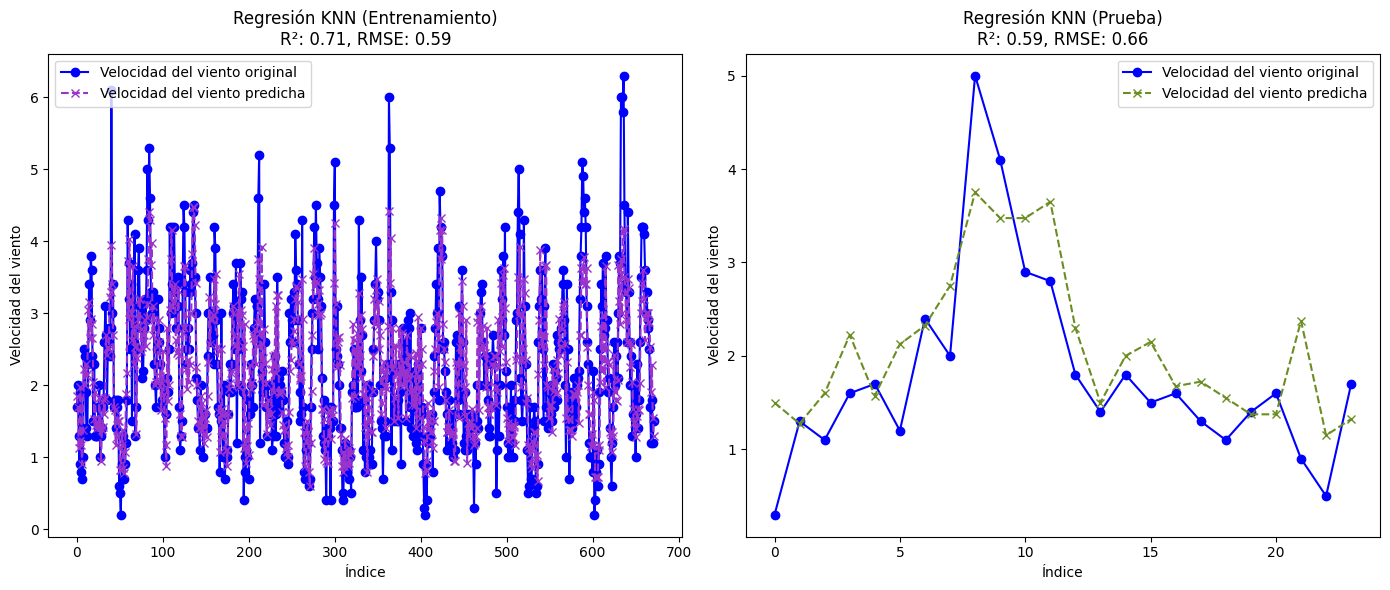

In [170]:
metricas = []
dias = 28
hora = 8
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloknn2.fit(X_train, y_train)
    
    # Entrenamiento
    y_predicciontrain = modeloknn2.predict(X_train)
    rmsetrain = mean_squared_error(y_train, y_predicciontrain, squared=False)
    mapetrain = MAPE(y_train, y_predicciontrain)
    r2train = r2_score(y_train, y_predicciontrain)
    
    # Test
    y_prediccion = modeloknn2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión KNN',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value': ljungbox,
        'Jarque-Bera p-value': jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_predicciontrain)), y_predicciontrain, label="Velocidad del viento predicha", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión KNN (Entrenamiento)\nR²: {r2train:.2f}, RMSE: {rmsetrain:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_prediccion)), y_prediccion, label="Velocidad del viento predicha", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión KNN (Prueba)\nR²: {r2:.2f}, RMSE: {rmse:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()


Al observar la gráfica del conjunto de entrenamiento, podemos concluir que el modelo es bastante bueno, ya que presenta un coeficiente de determinación (R²) de `0.72` y un error cuadrático medio (RMSE) de `0.58`. Esto se refleja en que las líneas correspondientes a la velocidad del viento predicha siguen prácticamente la misma tendencia que los datos reales del conjunto de entrenamiento.

 En cuanto al conjunto de prueba, el modelo presenta un R² de `0.72` y un RMSE de `0.54`. Aunque en su mayoría las predicciones siguen de manera coherente el comportamiento de los datos originales, se observan pequeños segmentos donde las predicciones se desvían ligeramente de la tendencia real.

#### **MODELO RIDGE**

In [171]:
# ESPACIO DE BÚSQUEDA
espaciobusqueda = [
    Real(0.001, 10, name='alpha'),  # Alpha es el parámetro de regularización en Ridge
]

# FUNCIÓN OBJETIVO
def funcionobjetivo(params):
    alpha = params[0]  # Parámetro es alpha
    
    # Modelo con parámetro
    mejorridge = Ridge(alpha=alpha)
    
    # Obtener los pliegues 
    conjuntopliegues = pliegues(X, 24, 21)  
    
    mse_total = 0
    num_pliegues = len(conjuntopliegues)
    
    for train_indices, test_indices in conjuntopliegues:
        
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
       
        mejorridge.fit(X_train, y_train)
        y_pred = mejorridge.predict(X_test)
        
        mse = np.mean((y_test - y_pred) ** 2)
        mse_total += mse

    mse_promedio = mse_total / num_pliegues
    
    # Devolver el MSE promedio como la función de pérdida que gp_minimize minimizará
    return mse_promedio

result = gp_minimize(funcionobjetivo, espaciobusqueda, n_calls=50, random_state=0)


print(f"Mejores hiperparámetros: alpha = {result.x[0]}")

Mejores hiperparámetros: alpha = 10.0


In [172]:
modeloridge2 = Ridge(alpha=10)
metricas = []
dias = 21
hora = 24
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloridge2.fit(X_train, y_train)
    y_prediccion= modeloridge2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Ridge',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
dataridge = pd.DataFrame(metricas)
dataridge = dataridge.loc[dataridge['RMSE'].idxmin()]
dataridge = pd.DataFrame(dataridge)
dataridge

,1
Modelo,Regresión Ridge
Dias,21
Hora,24
MAPE,13.365581
RMSE,0.283596
R^2,0.875062
Ljung-Box p-value,0.384846
Jarque-Bera p-value,0.195623


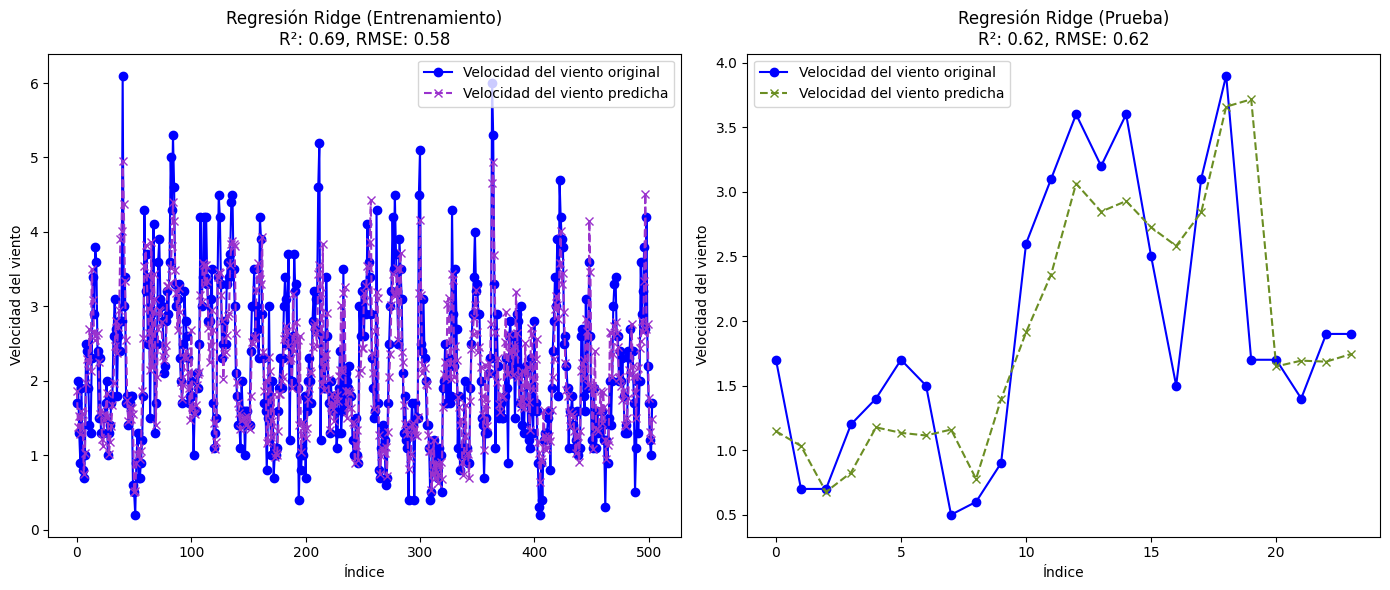

In [174]:
metricas = []
dias = 21
hora = 24
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloridge2.fit(X_train, y_train)
    
    # Entrenamiento
    y_predicciontrain = modeloridge2.predict(X_train)
    rmsetrain = mean_squared_error(y_train, y_predicciontrain, squared=False)
    mapetrain = MAPE(y_train, y_predicciontrain)
    r2train = r2_score(y_train, y_predicciontrain)
    
    # Test
    y_prediccion = modeloridge2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Ridge',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value': ljungbox,
        'Jarque-Bera p-value': jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_predicciontrain)), y_predicciontrain, label="Velocidad del viento predicha", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Ridge (Entrenamiento)\nR²: {r2train:.2f}, RMSE: {rmsetrain:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_prediccion)), y_prediccion, label="Velocidad del viento predicha", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Ridge (Prueba)\nR²: {r2:.2f}, RMSE: {rmse:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()


Al observar la gráfica del conjunto de entrenamiento, podemos concluir que el modelo es bastante bueno, ya que presenta un coeficiente de determinación (R²) de `0.69` y un error cuadrático medio (RMSE) de `0.58`. Esto se refleja en que las líneas correspondientes a la velocidad del viento predicha siguen prácticamente la misma tendencia que los datos reales del conjunto de entrenamiento.

En cuanto al conjunto de prueba, el modelo presenta un R² y un RMSE de `0.62` y Aunque en su mayoría las predicciones siguen de manera coherente el comportamiento de los datos originales, se observan pequeños segmentos donde las predicciones se desvían ligeramente de la tendencia real.

In [ ]:
import pickle

# Guardado del modelo y los datos adicionales
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/PF_MODELOS/ridge_model_y_datos.pkl", "wb") as f:
    # Guardar el modelo entrenado
    pickle.dump(modeloridge, f)
    
    # Guardar el dataframe con las métricas
    pickle.dump(dataridge, f)
    
    # Guardar las variables adicionales
    pickle.dump(y_train, f)
    pickle.dump(y_prediccion, f)
    pickle.dump(y_predicciontrain, f)
    pickle.dump(y_test, f)

#### **MODELO LASSO**

In [175]:
# ESPACIO DE BÚSQUEDA
espaciobusqueda = [
    Real(0.1, 10, name='alpha'),  # Alpha es el parámetro de regularización en Lasso
]

# FUNCIÓN OBJETIVO
def funcionobjetivo(params):
    alpha = params[0]  # Parámetro es alpha
    
    # Modelo Lasso con parámetro
    mejorlasso = Lasso(alpha=alpha)
    
    # Obtener los pliegues
    conjuntopliegues = pliegues(X, 7, 7)  
    
    mse_total = 0
    num_pliegues = len(conjuntopliegues)
    
    for train_indices, test_indices in conjuntopliegues:
        
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
        # Entrenar el modelo Lasso
        mejorlasso.fit(X_train, y_train)
        y_pred = mejorlasso.predict(X_test)
        
        # Calcular el error cuadrático medio (MSE)
        mse = np.mean((y_test - y_pred) ** 2)
        mse_total += mse

    mse_promedio = mse_total / num_pliegues
    
    # Devolver el MSE promedio como la función de pérdida que gp_minimize minimizará
    return mse_promedio

# Ejecutar la optimización bayesiana para minimizar el MSE promedio
result = gp_minimize(funcionobjetivo, espaciobusqueda, n_calls=50, random_state=0)

# Imprimir el mejor valor de alpha encontrado
print(f"Mejores hiperparámetros: alpha = {result.x[0]}")


Mejores hiperparámetros: alpha = 0.1


In [176]:
modelolasso2 = Lasso(alpha=0.1)
metricas = []
dias = 7
hora = 7
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modelolasso2.fit(X_train, y_train)
    y_prediccion= modelolasso2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Lasso',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
datalasso = pd.DataFrame(metricas)
datalasso = datalasso.loc[datalasso['RMSE'].idxmin()]
datalasso = pd.DataFrame(datalasso)
datalasso

,239
Modelo,Regresión Lasso
Dias,7
Hora,7
MAPE,13.756313
RMSE,0.333403
R^2,0.74215
Ljung-Box p-value,0.666188
Jarque-Bera p-value,0.802302


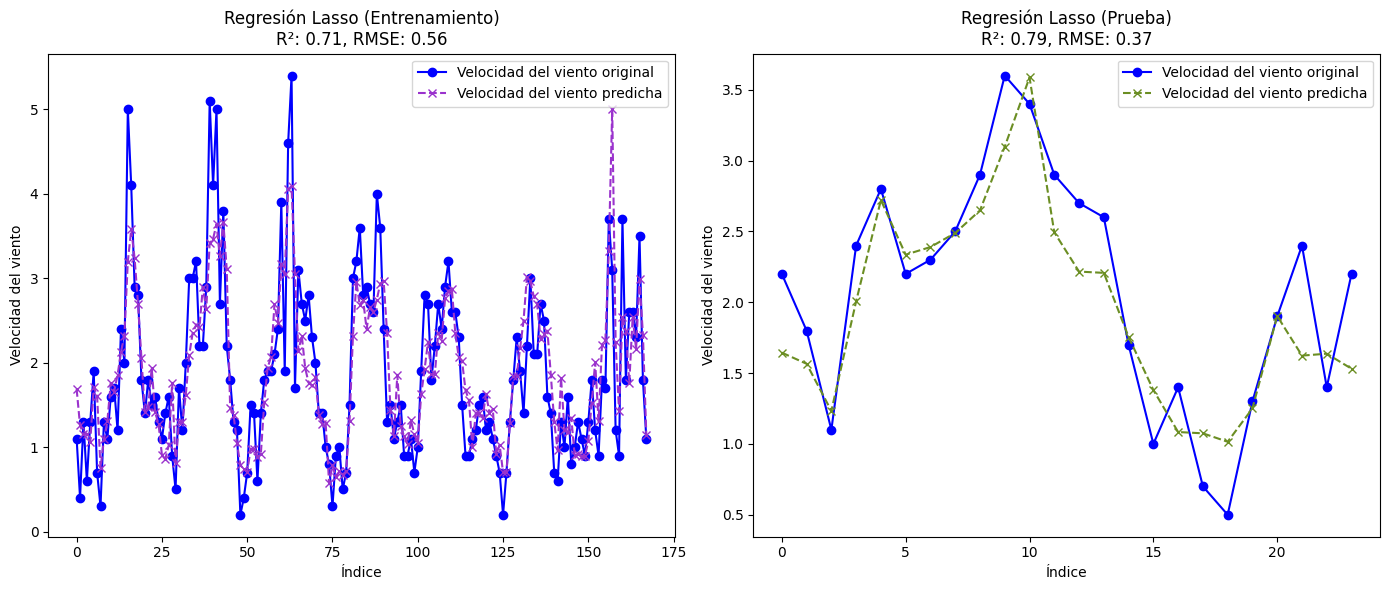

In [177]:
metricas = []
dias = 7
hora = 7
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modelolasso2.fit(X_train, y_train)
    
    # Entrenamiento
    y_predicciontrain = modelolasso2.predict(X_train)
    rmsetrain = mean_squared_error(y_train, y_predicciontrain, squared=False)
    mapetrain = MAPE(y_train, y_predicciontrain)
    r2train = r2_score(y_train, y_predicciontrain)
    
    # Test
    y_prediccion = modelolasso2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Lasso',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value': ljungbox,
        'Jarque-Bera p-value': jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_predicciontrain)), y_predicciontrain, label="Velocidad del viento predicha", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lasso (Entrenamiento)\nR²: {r2train:.2f}, RMSE: {rmsetrain:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_prediccion)), y_prediccion, label="Velocidad del viento predicha", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Regresión Lasso (Prueba)\nR²: {r2:.2f}, RMSE: {rmse:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()


Al observar la gráfica del conjunto de entrenamiento, podemos concluir que el modelo es bastante bueno, ya que presenta un coeficiente de determinación (R²) de `0.71` y un error cuadrático medio (RMSE) de `0.56`. Esto se refleja en que las líneas correspondientes a la velocidad del viento predicha siguen prácticamente la misma tendencia que los datos reales del conjunto de entrenamiento.

En cuanto al conjunto de prueba, el modelo presenta un R² de `0.79` y un RMSE de `0.37`. Podemos observar que la línea de velocidad del viento intenta seguir la tendencia de la original, sin embargo, falla en algunos segmentos. Esto significa que el modelo puede mejorar.


In [178]:
import pickle

# Guardado del modelo KNN y el dataframe dataknn
with open("C:/Users/valcd/OneDrive/Escritorio/MachinelearningUN/PF_MODELOS/lasso_model_y_datos.pkl", "wb") as f:
    pickle.dump(modelolasso, f)  # Guardar el modelo entrenado
    pickle.dump(datalasso, f)    # Guardar el dataframe con las métricas



#### **MODELO DECISION TREE REGRESSOR**

In [38]:
# ESPACIO DE BÚSQUEDA
espaciobusqueda = [
    Integer(1, 50, name='max_depth'),           # Profundidad máxima
       # Muestras mínimas para dividir un nodo
]


# FUNCIÓN OBJETIVO
def funcionobjetivo(params):
    max_depth = params[0]  # Parámetro es la profundidad máxima
    
    
    # Modelo Decision Tree Regressor con el parámetro
    mejordectree = DecisionTreeRegressor(max_depth=max_depth, random_state=21)
    
    # Obtener los pliegues
    conjuntopliegues = pliegues(X, 14, 3)  
    
    mse_total = 0
    num_pliegues = len(conjuntopliegues)
    
    for train_indices, test_indices in conjuntopliegues:
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
        # Entrenar el modelo Decision Tree
        mejordectree.fit(X_train, y_train)
        y_pred = mejordectree.predict(X_test)
        
        # Calcular el error cuadrático medio (MSE)
        mse = np.mean((y_test - y_pred) ** 2)
        mse_total += mse

    mse_promedio = mse_total / num_pliegues
    
    # Devolver el MSE promedio como la función de pérdida
    return mse_promedio

# Ejecutar la optimización bayesiana para minimizar el MSE promedio
result = gp_minimize(funcionobjetivo, espaciobusqueda, n_calls=20, random_state=21)

# Imprimir el mejor valor de max_depth encontrado
print(f"Mejores hiperparámetros: max_depth = {result.x[0]} ")


Mejores hiperparámetros: max_depth = 3 


In [11]:
modelodectree2 = DecisionTreeRegressor(max_depth = 150, min_samples_split = 26 , random_state=21)
metricas = []
dias = 14
hora = 3
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modelodectree2.fit(X_train, y_train)
    y_prediccion= modelodectree2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Random Forest',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
datadectree = pd.DataFrame(metricas)
datadectree = datadectree.loc[datadectree['RMSE'].idxmin()]
datadectree = pd.DataFrame(datadectree)
datadectree

,250
Modelo,Regresión Random Forest
Dias,14
Hora,3
MAPE,18.55245
RMSE,0.35192
R^2,0.868471
Ljung-Box p-value,0.025182
Jarque-Bera p-value,0.931231


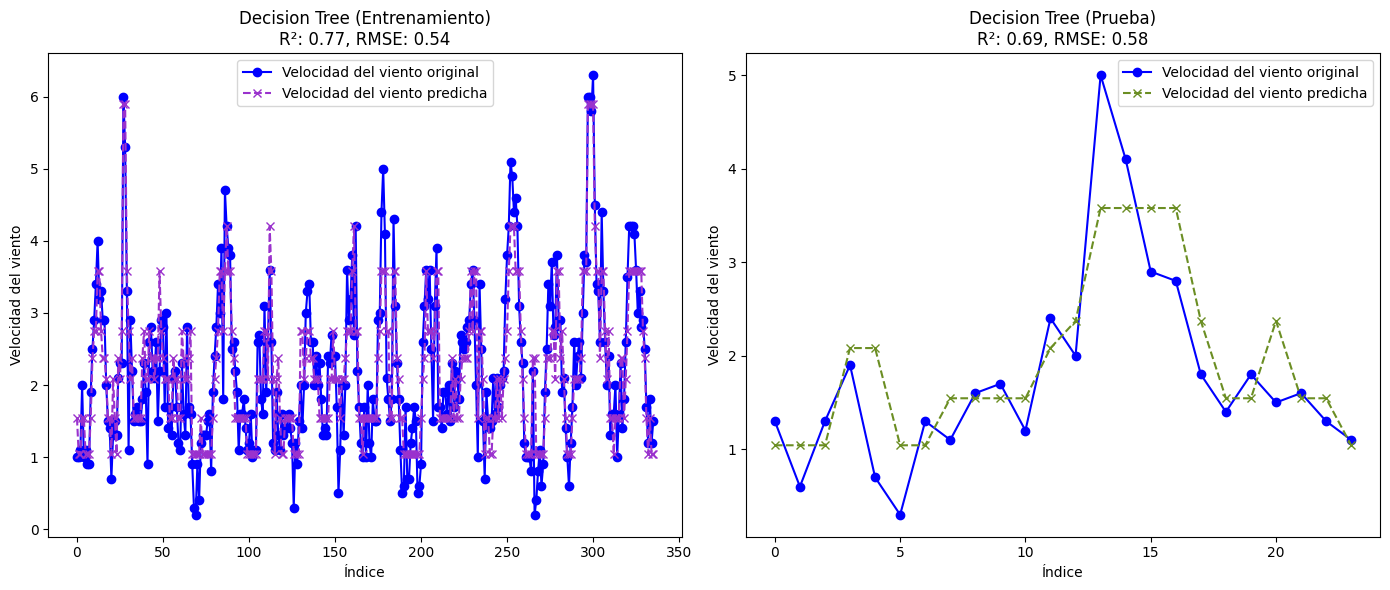

In [9]:
modelodectree2 = DecisionTreeRegressor(max_depth = 3, random_state=21)

metricas = []
dias = 14
hora = 3
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modelodectree2.fit(X_train, y_train)
    
    # Entrenamiento
    y_predicciontrain = modelodectree2.predict(X_train)
    rmsetrain = mean_squared_error(y_train, y_predicciontrain, squared=False)
    mapetrain = MAPE(y_train, y_predicciontrain)
    r2train = r2_score(y_train, y_predicciontrain)
    
    # Test
    y_prediccion = modelodectree2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Decision Tree',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value': ljungbox,
        'Jarque-Bera p-value': jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_predicciontrain)), y_predicciontrain, label="Velocidad del viento predicha", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Decision Tree (Entrenamiento)\nR²: {r2train:.2f}, RMSE: {rmsetrain:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_prediccion)), y_prediccion, label="Velocidad del viento predicha", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Decision Tree (Prueba)\nR²: {r2:.2f}, RMSE: {rmse:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

Al observar la gráfica del modelo en el conjunto de entrenamiento, notamos un R² de `0.77` y un RMSE de `0.54`, lo cual indica que el modelo tiene una considerable capacidad de predicción. Esto se refleja en el patrón de la línea predicha, que sigue de manera adecuada la tendencia de los datos originales. Sin embargo, el modelo no es perfecto, ya que se observan discrepancias en algunos picos, donde las predicciones superan los valores reales.

Por otro lado, en el modelo del conjunto de prueba, el R² es de `0.69` y el RMSE de `0.58`, lo que indica que el desempeño es menor en comparación con el entrenamiento, aunque sigue siendo aceptable. Se observa que las líneas predichas logran, relativamente, seguir el mismo patrón que la original, salvo en aquellos casos donde las predicciones aparecen como segmentos horizontales. Este comportamiento es común en los árboles de decisión, ya que asignan valores constantes dentro de ciertas regiones.

#### **MODELO RANDOM FOREST**

In [54]:
from skopt import gp_minimize
from skopt.space import Integer

# ESPACIO DE BÚSQUEDA
espaciobusqueda = [
    Integer(10,150, name='n_estimators') ,  # Número de árboles
    Integer(5,20, name='max_depth')        # Profundidad máxima
]


# FUNCIÓN OBJETIVO
def funcionobjetivo(params):
    n_estimators = params[0]        # Número de árboles
    max_depth = params[1]           # Profundidad máxima
      # Muestras mínimas en hojas
    
    # Modelo Random Forest con parámetros
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=21
    )
    
    # Obtener los pliegues
    conjuntopliegues = pliegues(X, 7, 18)  
    
    mse_total = 0
    num_pliegues = len(conjuntopliegues)
    
    for train_indices, test_indices in conjuntopliegues:
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
        # Entrenar el modelo Random Forest
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        
        # Calcular el error cuadrático medio (MSE)
        mse = np.mean((y_test - y_pred) ** 2)
        mse_total += mse

    mse_promedio = mse_total / num_pliegues
    
    # Devolver el MSE promedio como la función de pérdida
    return mse_promedio

# Ejecutar la optimización bayesiana para minimizar el MSE promedio
result = gp_minimize(funcionobjetivo, espaciobusqueda, n_calls=30, random_state=21)

# Imprimir los mejores valores de hiperparámetros encontrados
print(f"Mejores hiperparámetros: n_estimators = {result.x[0]}, max_depth = {result.x[1]}")


Mejores hiperparámetros: n_estimators = 97, max_depth = 5


In [56]:
modeloranfor2 = RandomForestRegressor(n_estimators = 97, max_depth = 5, random_state=21)
metricas = []
dias = 7
hora = 18
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloranfor2.fit(X_train, y_train)
    y_prediccion= modeloranfor2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión Random Forest',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
dataranfor = pd.DataFrame(metricas)
dataranfor = dataranfor.loc[dataranfor['RMSE'].idxmin()]
dataranfor = pd.DataFrame(dataranfor)
dataranfor

,4
Modelo,Regresión Random Forest
Dias,7
Hora,18
MAPE,16.629372
RMSE,0.302459
R^2,0.929764
Ljung-Box p-value,0.0802
Jarque-Bera p-value,0.542949


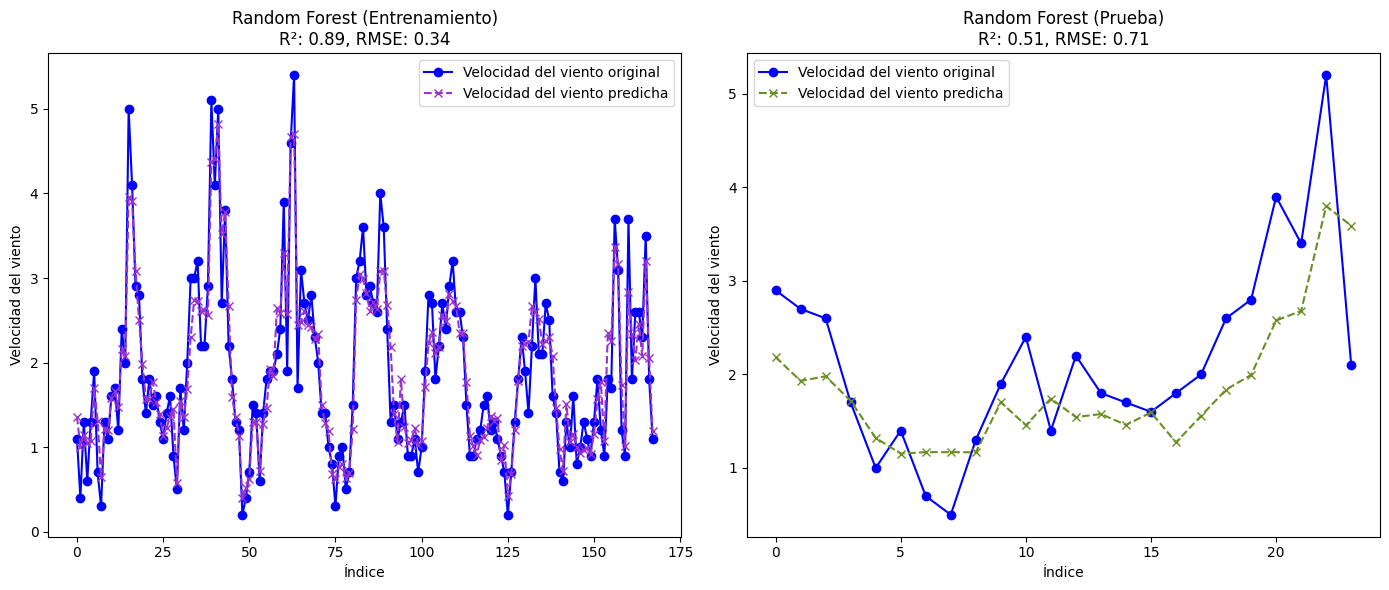

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

modeloranfor2 = RandomForestRegressor(n_estimators = 97, max_depth = 5, random_state=21)

metricas = []
dias = 7
hora = 18
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloranfor2.fit(X_train, y_train)
    
    # Entrenamiento
    y_predicciontrain = modeloranfor2.predict(X_train)
    rmsetrain = mean_squared_error(y_train, y_predicciontrain, squared=False)
    mapetrain = MAPE(y_train, y_predicciontrain)
    r2train = r2_score(y_train, y_predicciontrain)
    
    # Test
    y_prediccion = modeloranfor2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Random Forest',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value': ljungbox,
        'Jarque-Bera p-value': jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_predicciontrain)), y_predicciontrain, label="Velocidad del viento predicha", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Random Forest (Entrenamiento)\nR²: {r2train:.2f}, RMSE: {rmsetrain:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_prediccion)), y_prediccion, label="Velocidad del viento predicha", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"Random Forest (Prueba)\nR²: {r2:.2f}, RMSE: {rmse:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

En el conjunto de entrenamiento, el modelo Random Forest presenta un R² de `0.89` y un RMSE de `0.34`, esto se resume en que el modelo cuenta con excelente desempeño. La línea de las predicciones sigue casi perfectamente la tendencia de los datos orginales, capturando incluso picos y caídas abruptas. Esto sugiere que el modelo está bien ajustado a los datos de entrenamiento.

Por otro lado, en el conjunto de prueba, el modelo no logra ajustarse adecuadamente al comportamiento de los datos, como se refleja en un R² de `0.51` y un RMSE de `0.71`. Aunque las predicciones logran seguir parcialmente la tendencia original, se observan diferencias significativas respecto a los valores reales, especialmente en los puntos de mayor variación, como picos y valles. Esto indica que el modelo tiene problemas para adaptarse de manera efectiva a datos nuevos o no vistos.

#### **MODELO XGBOOST**

In [ ]:
from skopt.space import Integer, Categorical
from xgboost import XGBRegressor


espaciobusqueda = [
    Integer(1, 10, name='xgb__max_depth'),  # Profundidad de los árboles
    Categorical([100, 200, 500], name='xgb__n_estimators'),  # Número de árboles
    Categorical([0.01, 0.1, 0.2], name='xgb__learning_rate')  # Tasa de aprendizaje
]

# Función objetivo
def funcionobjetivo(params):
    max_depth, n_estimators, learning_rate = params

    # Modelo XGBoost con los parámetros
    xgb = XGBRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=21,
        verbosity=0
    )
    
    # Obtener los pliegues (debes implementar la función pliegues)
    conjuntopliegues = pliegues(X, 21, 14)  # Divisiones temporales según tus datos
    
    mse_total = 0
    num_pliegues = len(conjuntopliegues)
    
    for train_indices, test_indices in conjuntopliegues:
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
        
        # Entrenar el modelo XGBoost
        xgb.fit(X_train, y_train)
        y_pred = xgb.predict(X_test)
        
        # Calcular el error cuadrático medio (MSE)
        mse = mean_squared_error(y_test, y_pred)
        mse_total += mse

    mse_promedio = mse_total / num_pliegues
    
    # Devolver el MSE promedio como función de pérdida
    return mse_promedio

# Ejecutar optimización bayesiana
result = gp_minimize(funcionobjetivo, espaciobusqueda, n_calls=20, random_state=21)

# Imprimir mejores hiperparámetros
print(f"Mejores hiperparámetros: max_depth = {result.x[0]}, n_estimators = {result.x[1]}, learning_rate = {result.x[2]}")


Mejores hiperparámetros: max_depth = 2, n_estimators = 500, learning_rate = 0.01


In [46]:
modeloxgboost2 = XGBRegressor(max_depth = 2, n_estimators = 500, learning_rate = 0.01, random_state=21)
metricas = []
dias = 21
hora = 14
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloxgboost2.fit(X_train, y_train)
    y_prediccion= modeloxgboost2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión XGBoost',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
dataxgboost = pd.DataFrame(metricas)
dataxgboost = dataxgboost.loc[dataxgboost['RMSE'].idxmin()]
dataxgboost = pd.DataFrame(dataxgboost)
dataxgboost

,7
Modelo,Regresión XGBoost
Dias,21
Hora,14
MAPE,9.791959
RMSE,0.303648
R^2,0.837365
Ljung-Box p-value,0.968461
Jarque-Bera p-value,0.672995


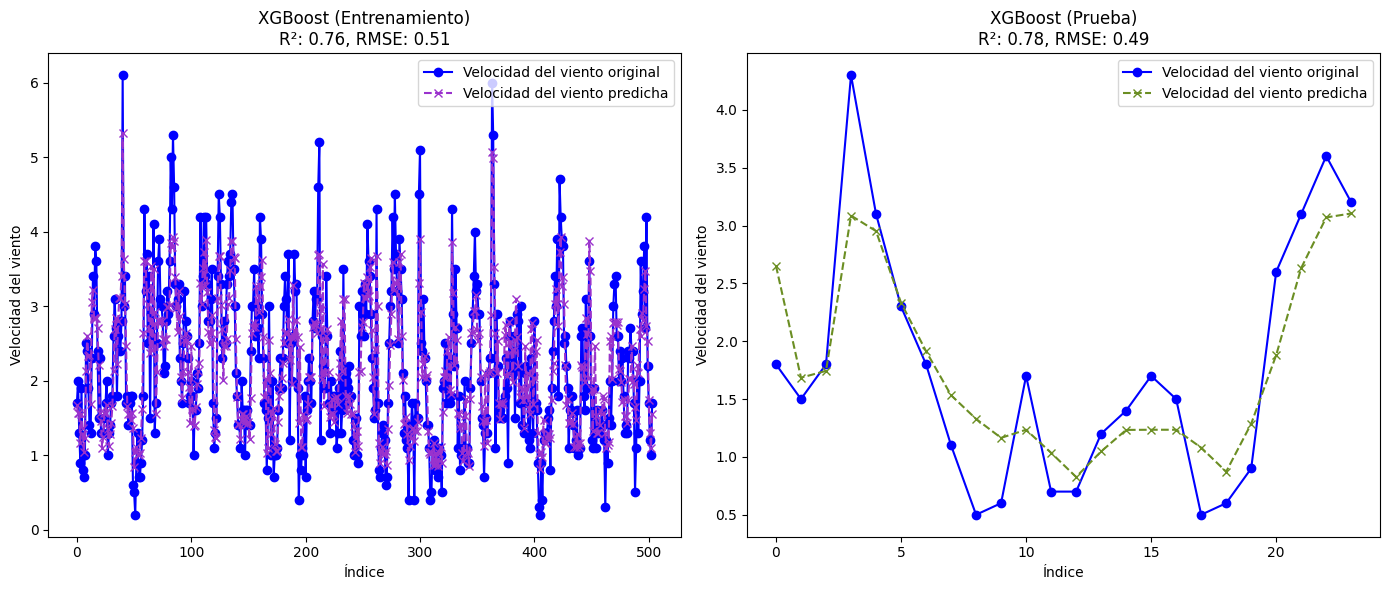

In [47]:
metricas = []
dias = 21
hora = 14
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modeloxgboost2.fit(X_train, y_train)
    
    # Entrenamiento
    y_predicciontrain = modeloxgboost2.predict(X_train)
    rmsetrain = mean_squared_error(y_train, y_predicciontrain, squared=False)
    mapetrain = MAPE(y_train, y_predicciontrain)
    r2train = r2_score(y_train, y_predicciontrain)
    
    # Test
    y_prediccion = modeloxgboost2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'XGBoost',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value': ljungbox,
        'Jarque-Bera p-value': jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_predicciontrain)), y_predicciontrain, label="Velocidad del viento predicha", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"XGBoost (Entrenamiento)\nR²: {r2train:.2f}, RMSE: {rmsetrain:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_prediccion)), y_prediccion, label="Velocidad del viento predicha", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"XGBoost (Prueba)\nR²: {r2:.2f}, RMSE: {rmse:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

Al observar la gráfica del conjunto de entrenamiento, podemos concluir que el modelo es bastante bueno, ya que presenta un coeficiente de determinación (R²) de `0.76` y un error cuadrático medio (RMSE) de `0.51`. Esto se refleja en que las líneas correspondientes a la velocidad del viento predicha siguen prácticamente la misma tendencia que los datos reales del conjunto de entrenamiento.

En cuanto al conjunto de prueba, el modelo presenta un R² de `0.78` y un RMSE de `0.49`. Podemos observar que la línea de velocidad del viento intenta seguir la tendencia de la original, sin embargo, falla en algunos segmentos. Esto significa que el modelo puede mejorar.

#### **MODELO SVR**

In [49]:
modelosvr2 = SVR(C = 2.715390236475287, kernel = "rbf", gamma = "auto")
metricas = []
dias = 21
hora = 4
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modelosvr2.fit(X_train, y_train)
    y_prediccion= modelosvr2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'Regresión con Máqinas de Soporte Vectorial',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value' : ljungbox,
        'Jarque-Bera p-value' : jarquebera
    })   
    iniciotrain = fintrain  
datasvm = pd.DataFrame(metricas)
datasvm = datasvm.loc[datasvm['RMSE'].idxmin()]
datasvm = pd.DataFrame(datasvm)
datasvm

,30
Modelo,Regresión con Máqinas de Soporte Vectorial
Dias,21
Hora,4
MAPE,11.792695
RMSE,0.302481
R^2,0.921906
Ljung-Box p-value,0.27866
Jarque-Bera p-value,0.549737


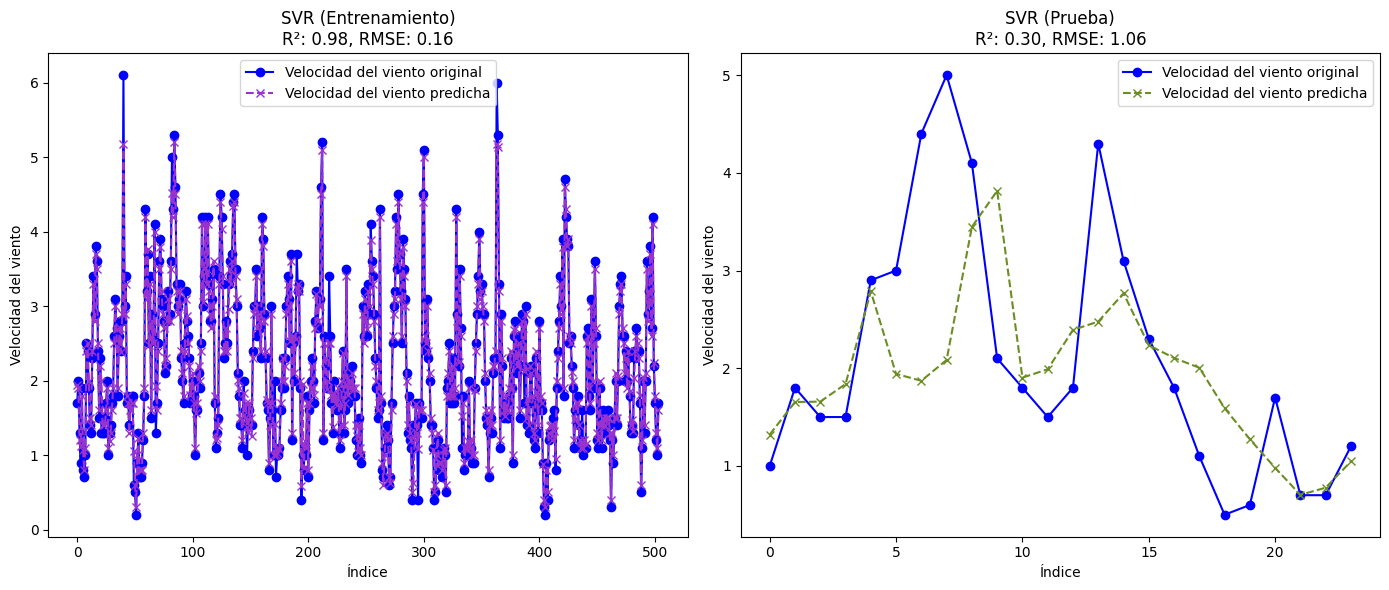

In [51]:
modelosvr2 = SVR(C = 2.715390236475287, kernel = "rbf", gamma = "auto")
metricas = []
dias = 21
hora = 4
iniciotrain = 0
while (iniciotrain + (dias * 24) + 1) < len(X):  # Mientras que el tamaño del pliegue más la hora sea menor que la longitud de los datos
    fintrain = iniciotrain + (dias * 24)   
    X_train, y_train, X_test, y_test = plieguess(iniciotrain, fintrain, hora)   
    modelosvr2.fit(X_train, y_train)
    
    # Entrenamiento
    y_predicciontrain = modelosvr2.predict(X_train)
    rmsetrain = mean_squared_error(y_train, y_predicciontrain, squared=False)
    mapetrain = MAPE(y_train, y_predicciontrain)
    r2train = r2_score(y_train, y_predicciontrain)
    
    # Test
    y_prediccion = modelosvr2.predict(X_test)       
    rmse = mean_squared_error(y_test, y_prediccion, squared=False)
    mape = MAPE(y_test, y_prediccion)
    r2 = r2_score(y_test, y_prediccion)
    
    ljungbox, jarquebera = residuos(y_test, y_prediccion)   
    metricas.append({
        'Modelo': 'SVR',
        'Dias': dias,
        'Hora': hora,
        'MAPE': mape,
        'RMSE': rmse,
        'R^2': r2,
        'Ljung-Box p-value': ljungbox,
        'Jarque-Bera p-value': jarquebera
    })   
    iniciotrain = fintrain  # Actualizar el inicio para el siguiente pliegue

# Gráfico con lineplot
plt.figure(figsize=(14, 6))

# Conjunto de entrenamiento
plt.subplot(1, 2, 1)
plt.plot(range(len(y_train)), y_train, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_predicciontrain)), y_predicciontrain, label="Velocidad del viento predicha", color='#9A32CD', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"SVR (Entrenamiento)\nR²: {r2train:.2f}, RMSE: {rmsetrain:.2f}")
plt.legend()

# Conjunto de prueba
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label="Velocidad del viento original", color='blue', linestyle='-', marker='o')
plt.plot(range(len(y_prediccion)), y_prediccion, label="Velocidad del viento predicha", color='#6B8E23', linestyle='--', marker='x')
plt.xlabel("Índice")
plt.ylabel("Velocidad del viento")
plt.title(f"SVR (Prueba)\nR²: {r2:.2f}, RMSE: {rmse:.2f}")
plt.legend()

# Mostrar gráfico
plt.tight_layout()
plt.show()

En la gráfica del modelo en el conjunto de entrenamiento, se observa que las predicciones siguen casi perfectamente la tendencia de los datos originales, al punto de que ambas líneas son prácticamente indistinguibles, incluso en los picos y valles. Esto se refleja en los valores de R² (`0.98`) y RMSE (`0.16`), que indican que el modelo logra un ajuste muy preciso en este conjunto.

Por otro lado, en la gráfica del conjunto de prueba, se nota que las predicciones no logran ajustarse bien al comportamiento de los datos originales. Aunque intentan seguir el patrón general, se presentan discrepancias importantes, sobre todo en los picos y valles, donde las predicciones fallan en capturar los valores extremos. Esto se ve reflejado en un R² de `0.30` y un RMSE de `1.06`, que evidencian un desempeño mucho menor en comparación con el entrenamiento.